## Data Cleaning

### Variable selection, removing high missing etc

Compute spreads: For every country-month, spread = yield_country − US10y. Drop USA afterwards.
-	Annual/quarterly → monthly via step functions:
-	ND-GAIN, debt/GDP, primary balance, governance: carry same value across months in period.
-	GDP YoY: compute from quarterly SA real GDP; carry to three months of each quarter.
-	Avoid linear interpolation of ratios.
-	Lags & dynamics: Add 1–2 lags of the spread; lag global factors by 1 month (if using them instead of time FE).
-	Scaling: Z-score continuous controls (not Y or T). Log/Δ where standard (e.g., Δlog Brent, Δlog FX/NEER).
-	Outliers: Gentle winsorization of spreads and ΔFX at 1–99% if necessary (document thresholds).
Quality gate: All series on common calendar; transformations logged in a data methods sheet.

Phase 3 — Transformations & standardization
-	Compute spreads: For every country-month, spread = yield_country − US10y. Drop USA afterwards.
-	Annual/quarterly → monthly via step functions:
-	ND-GAIN, debt/GDP, primary balance, governance: carry same value across months in period.
-	GDP YoY: compute from quarterly SA real GDP; carry to three months of each quarter.
-	Avoid linear interpolation of ratios.
-	Lags & dynamics: Add 1–2 lags of the spread; lag global factors by 1 month (if using them instead of time FE).
-	Scaling: Z-score continuous controls (not Y or T). Log/Δ where standard (e.g., Δlog Brent, Δlog FX/NEER).
-	Outliers: Gentle winsorization of spreads and ΔFX at 1–99% if necessary (document thresholds).

Quality gate: All series on common calendar; transformations logged in a data methods sheet.

In [2]:
## Phase 3 - Transformations & standardization
### Load Baseline Dataset and Create Fixed Effects
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
import os

warnings.filterwarnings('ignore')

# Use the provided absolute path to the baseline dataset
baseline_path = "/Users/leosgambato/Documents/GitHub/Capstone/data/processed/data_baseline_cleaned.csv"
if not os.path.exists(baseline_path):
    raise FileNotFoundError(
        f"Could not find the baseline dataset at '{baseline_path}'.\n"
        "Please ensure the file exists. If you have not yet created it, "
        "run the data processing scripts in 'src/' to generate the file."
    )

print("Loading baseline dataset...")
df_data = pd.read_csv(baseline_path)

# Convert date to datetime
if 'date' in df_data.columns:
    df_data['date'] = pd.to_datetime(df_data['date'])
else:
    raise KeyError("Column 'date' not found in the baseline dataset.")

print(f"Dataset loaded: {df_data.shape}")
print(f"Date range: {df_data['date'].min()} to {df_data['date'].max()}")
if 'iso3c' in df_data.columns:
    print(f"Countries: {df_data['iso3c'].nunique()}")
else:
    raise KeyError("Column 'iso3c' not found in the baseline dataset.")
print(f"Variables: {len(df_data.columns)}")

# Display first few rows
display(df_data.head())

# Create country fixed effects (dummy variables for each country)
print("Creating country fixed effects...")
country_dummies = pd.get_dummies(df_data['iso3c'], prefix='country')
print(f"Created {len(country_dummies.columns)} country dummies")

# Create time fixed effects (dummy variables for each year-month)
print("Creating time fixed effects...")
df_data['year_month'] = df_data['date'].dt.to_period('M')
time_dummies = pd.get_dummies(df_data['year_month'], prefix='time')
print(f"Created {len(time_dummies.columns)} time dummies")

# Add fixed effects to the main dataset
df_data = pd.concat([df_data, country_dummies, time_dummies], axis=1)

print(f"Dataset shape after adding fixed effects: {df_data.shape}")
print(f"Total variables now: {len(df_data.columns)}")

# Display sample of fixed effects
print("\nSample country dummies:")
display(country_dummies.iloc[:5, :10])

print("\nSample time dummies:")
display(time_dummies.iloc[:5, :10])

# Sort data by country and date for proper lagging
print("Creating lagged sovereign spread variable...")
df_data = df_data.sort_values(['iso3c', 'date'])

# Create lagged sovereign spread (y(t-1))
if 'sovereign_spread' in df_data.columns:
    df_data['sovereign_spread_lag1'] = df_data.groupby('iso3c')['sovereign_spread'].shift(1)
    # Create additional lags if needed
    df_data['sovereign_spread_lag2'] = df_data.groupby('iso3c')['sovereign_spread'].shift(2)
else:
    raise KeyError("Column 'sovereign_spread' not found in the baseline dataset.")

# Check lag creation
print(f"Dataset shape after adding lags: {df_data.shape}")
print(f"Variables including lags: {len(df_data.columns)}")

# Display sample of lagged variables
print("\nSample of lagged sovereign spread variables:")
lag_sample = df_data[['date', 'iso3c', 'sovereign_spread', 'sovereign_spread_lag1', 'sovereign_spread_lag2']].head(10)
display(lag_sample)

# Check for missing values in lagged variables
print(f"\nMissing values in sovereign_spread: {df_data['sovereign_spread'].isna().sum()}")
print(f"Missing values in sovereign_spread_lag1: {df_data['sovereign_spread_lag1'].isna().sum()}")
print(f"Missing values in sovereign_spread_lag2: {df_data['sovereign_spread_lag2'].isna().sum()}")

# Summary of the final dataset
print("="*80)
print("FINAL DATASET SUMMARY")
print("="*80)
print(f"Total observations: {len(df_data)}")
print(f"Total countries: {df_data['iso3c'].nunique()}")
print(f"Total variables: {len(df_data.columns)}")
print(f"Date range: {df_data['date'].min()} to {df_data['date'].max()}")

# List all variables
print(f"\nAll variables in the dataset:")
for i, col in enumerate(df_data.columns):
    print(f"{i+1:3d}. {col}")

# Check data types
print(f"\nData types:")
print(df_data.dtypes.value_counts())

# Check for any remaining missing values
print(f"\nMissing values summary:")
missing_summary = df_data.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)
if len(missing_summary) > 0:
    print(missing_summary)
else:
    print("No missing values in the dataset")

print("\nDataset ready for analysis!")


Loading baseline dataset...
Dataset loaded: (63338, 18)
Date range: 1980-01-01 00:00:00 to 2025-12-01 00:00:00
Countries: 80
Variables: 18


,date,iso3c,yield_with_spread,sovereign_spread,cpi_yoy,gdp_annual_growth_rate,gdp_per_capita,gross gdp,debt_to_gdp,deficit_to_gdp,current_account_balance,vulnerability,wgi_cc,wgi_ge,wgi_pv,wgi_rl,wgi_rq,wgi_va
0,2009-01-01,ARE,NaN,NaN,5.350238,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-02-01,ARE,NaN,NaN,5.350238,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2009-03-01,ARE,NaN,NaN,5.350238,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2009-04-01,ARE,NaN,NaN,1.474521,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2009-05-01,ARE,NaN,NaN,1.474521,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Creating country fixed effects...
Created 80 country dummies
Creating time fixed effects...
Created 552 time dummies
Dataset shape after adding fixed effects: (63338, 651)
Total variables now: 651

Sample country dummies:


,country_ARE,country_ARG,country_ARM,country_AUS,country_AUT,country_BEL,country_BGD,country_BGR,country_BRA,country_BWA
0,True,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False
4,True,False,False,False,False,False,False,False,False,False



Sample time dummies:


,time_1980-01,time_1980-02,time_1980-03,time_1980-04,time_1980-05,time_1980-06,time_1980-07,time_1980-08,time_1980-09,time_1980-10
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False


Creating lagged sovereign spread variable...
Dataset shape after adding lags: (63338, 653)
Variables including lags: 653

Sample of lagged sovereign spread variables:


,date,iso3c,sovereign_spread,sovereign_spread_lag1,sovereign_spread_lag2
0,2009-01-01,ARE,NaN,NaN,NaN
1,2009-02-01,ARE,NaN,NaN,NaN
2,2009-03-01,ARE,NaN,NaN,NaN
3,2009-04-01,ARE,NaN,NaN,NaN
4,2009-05-01,ARE,NaN,NaN,NaN
5,2009-06-01,ARE,NaN,NaN,NaN
6,2009-07-01,ARE,NaN,NaN,NaN
7,2009-08-01,ARE,NaN,NaN,NaN
8,2009-09-01,ARE,NaN,NaN,NaN
9,2009-10-01,ARE,NaN,NaN,NaN



Missing values in sovereign_spread: 18408
Missing values in sovereign_spread_lag1: 18410
Missing values in sovereign_spread_lag2: 18412
FINAL DATASET SUMMARY
Total observations: 63338
Total countries: 80
Total variables: 653
Date range: 1980-01-01 00:00:00 to 2025-12-01 00:00:00

All variables in the dataset:
  1. date
  2. iso3c
  3. yield_with_spread
  4. sovereign_spread
  5. cpi_yoy
  6. gdp_annual_growth_rate
  7. gdp_per_capita
  8. gross gdp
  9. debt_to_gdp
 10. deficit_to_gdp
 11. current_account_balance
 12. vulnerability
 13. wgi_cc
 14. wgi_ge
 15. wgi_pv
 16. wgi_rl
 17. wgi_rq
 18. wgi_va
 19. year_month
 20. country_ARE
 21. country_ARG
 22. country_ARM
 23. country_AUS
 24. country_AUT
 25. country_BEL
 26. country_BGD
 27. country_BGR
 28. country_BRA
 29. country_BWA
 30. country_CAN
 31. country_CHE
 32. country_CHL
 33. country_CHN
 34. country_CIV
 35. country_COL
 36. country_CYP
 37. country_CZE
 38. country_DEU
 39. country_DNK
 40. country_EGY
 41. country_ESP

In [2]:
## Data Cleaning
# Remove all rows for a country where 'sovereign_spread' is missing in at least 95% of that country's rows
# Also, report which countries had all such rows dropped

# Calculate, for each country, the fraction of rows where 'sovereign_spread' is missing
country_missing_pct = df_data.groupby('iso3c')['sovereign_spread'].apply(lambda x: x.isna().mean())

# Identify countries where >=95% of 'sovereign_spread' is missing
countries_to_drop = country_missing_pct[country_missing_pct >= 0.95].index.tolist()

print(f"\nCountries to drop due to >=95% missing 'sovereign_spread': {countries_to_drop}")

# Drop all rows for these countries
df_data = df_data[~df_data['iso3c'].isin(countries_to_drop)].reset_index(drop=True)



Countries to drop due to >=95% missing 'sovereign_spread': ['ARE', 'EST', 'ETH', 'GHA', 'KWT', 'MAR', 'SAU', 'UKR', 'URY', 'USA']


### Missingness phase 4

In [3]:
## 	Build a coverage report for each variable: overall % missing; % per country; first/last valid date; longest missing streak; average streak length.
import numpy as np
import pandas as pd

def get_missing_streaks(series):
    """
    Returns a list of lengths of consecutive missing value streaks in a pandas Series.
    """
    is_na = series.isna().values
    if not np.any(is_na):
        return []
    streaks = []
    streak = 0
    for val in is_na:
        if val:
            streak += 1
        else:
            if streak > 0:
                streaks.append(streak)
                streak = 0
    if streak > 0:
        streaks.append(streak)
    return streaks

def variable_coverage_report(df, country_col='iso3c', date_col='date'):
    print("\n" + "="*80)
    print("VARIABLE COVERAGE REPORT")
    print("="*80)
    variables = [col for col in df.columns if col not in [country_col, date_col]]
    for var in variables:
        print(f"\n--- Variable: {var} ---")
        s = df[var]
        # Overall % missing
        overall_missing_pct = s.isna().mean() * 100
        print(f"Overall % missing: {overall_missing_pct:.2f}%")
        # % missing per country
        missing_pct_by_country = df.groupby(country_col)[var].apply(lambda x: x.isna().mean() * 100)
        print("Missing % by country (top 10):")
        print(missing_pct_by_country.sort_values(ascending=False).head(10).to_string())
        # First/last valid date
        if s.notna().any():
            first_valid_idx = s.first_valid_index()
            last_valid_idx = s.last_valid_index()
            first_valid_date = df.loc[first_valid_idx, date_col]
            last_valid_date = df.loc[last_valid_idx, date_col]
            print(f"First valid date: {first_valid_date}")
            print(f"Last valid date: {last_valid_date}")
        else:
            print("No valid (non-missing) values for this variable.")
            continue
        # Longest missing streak and average streak length (overall)
        streaks = get_missing_streaks(s)
        if streaks:
            print(f"Longest missing streak: {max(streaks)}")
            print(f"Average missing streak length: {np.mean(streaks):.2f}")
        else:
            print("No missing streaks (no missing values).")
        # Per country: longest missing streak (top 5)
        country_streaks = df.groupby(country_col)[var].apply(get_missing_streaks)
        country_longest_streak = country_streaks.apply(lambda x: max(x) if x else 0)
        print("Longest missing streak by country (top 5):")
        print(country_longest_streak.sort_values(ascending=False).head(5).to_string())
    print("\n" + "="*80)
    print("End of VARIABLE COVERAGE REPORT")
    print("="*80)

# Run the coverage report
variable_coverage_report(df_data)



VARIABLE COVERAGE REPORT

--- Variable: yield_with_spread ---
Overall % missing: 29.06%
Missing % by country (top 10):
iso3c
ARE    100.0
SAU    100.0
ETH    100.0
GHA    100.0
KWT    100.0
EST    100.0
MAR    100.0
UKR    100.0
URY    100.0
USA    100.0
First valid date: 2010-09-01 00:00:00
Last valid date: 2025-07-01 00:00:00
Longest missing streak: 1863
Average missing streak length: 146.10
Longest missing streak by country (top 5):
iso3c
USA    852
CHL    696
LKA    592
QAT    530
CIV    496

--- Variable: sovereign_spread ---
Overall % missing: 29.06%
Missing % by country (top 10):
iso3c
ARE    100.0
SAU    100.0
ETH    100.0
GHA    100.0
KWT    100.0
EST    100.0
MAR    100.0
UKR    100.0
URY    100.0
USA    100.0
First valid date: 2010-09-01 00:00:00
Last valid date: 2025-07-01 00:00:00
Longest missing streak: 1863
Average missing streak length: 146.10
Longest missing streak by country (top 5):
iso3c
USA    852
CHL    696
LKA    592
QAT    530
CIV    496

--- Variable: cpi_yoy 

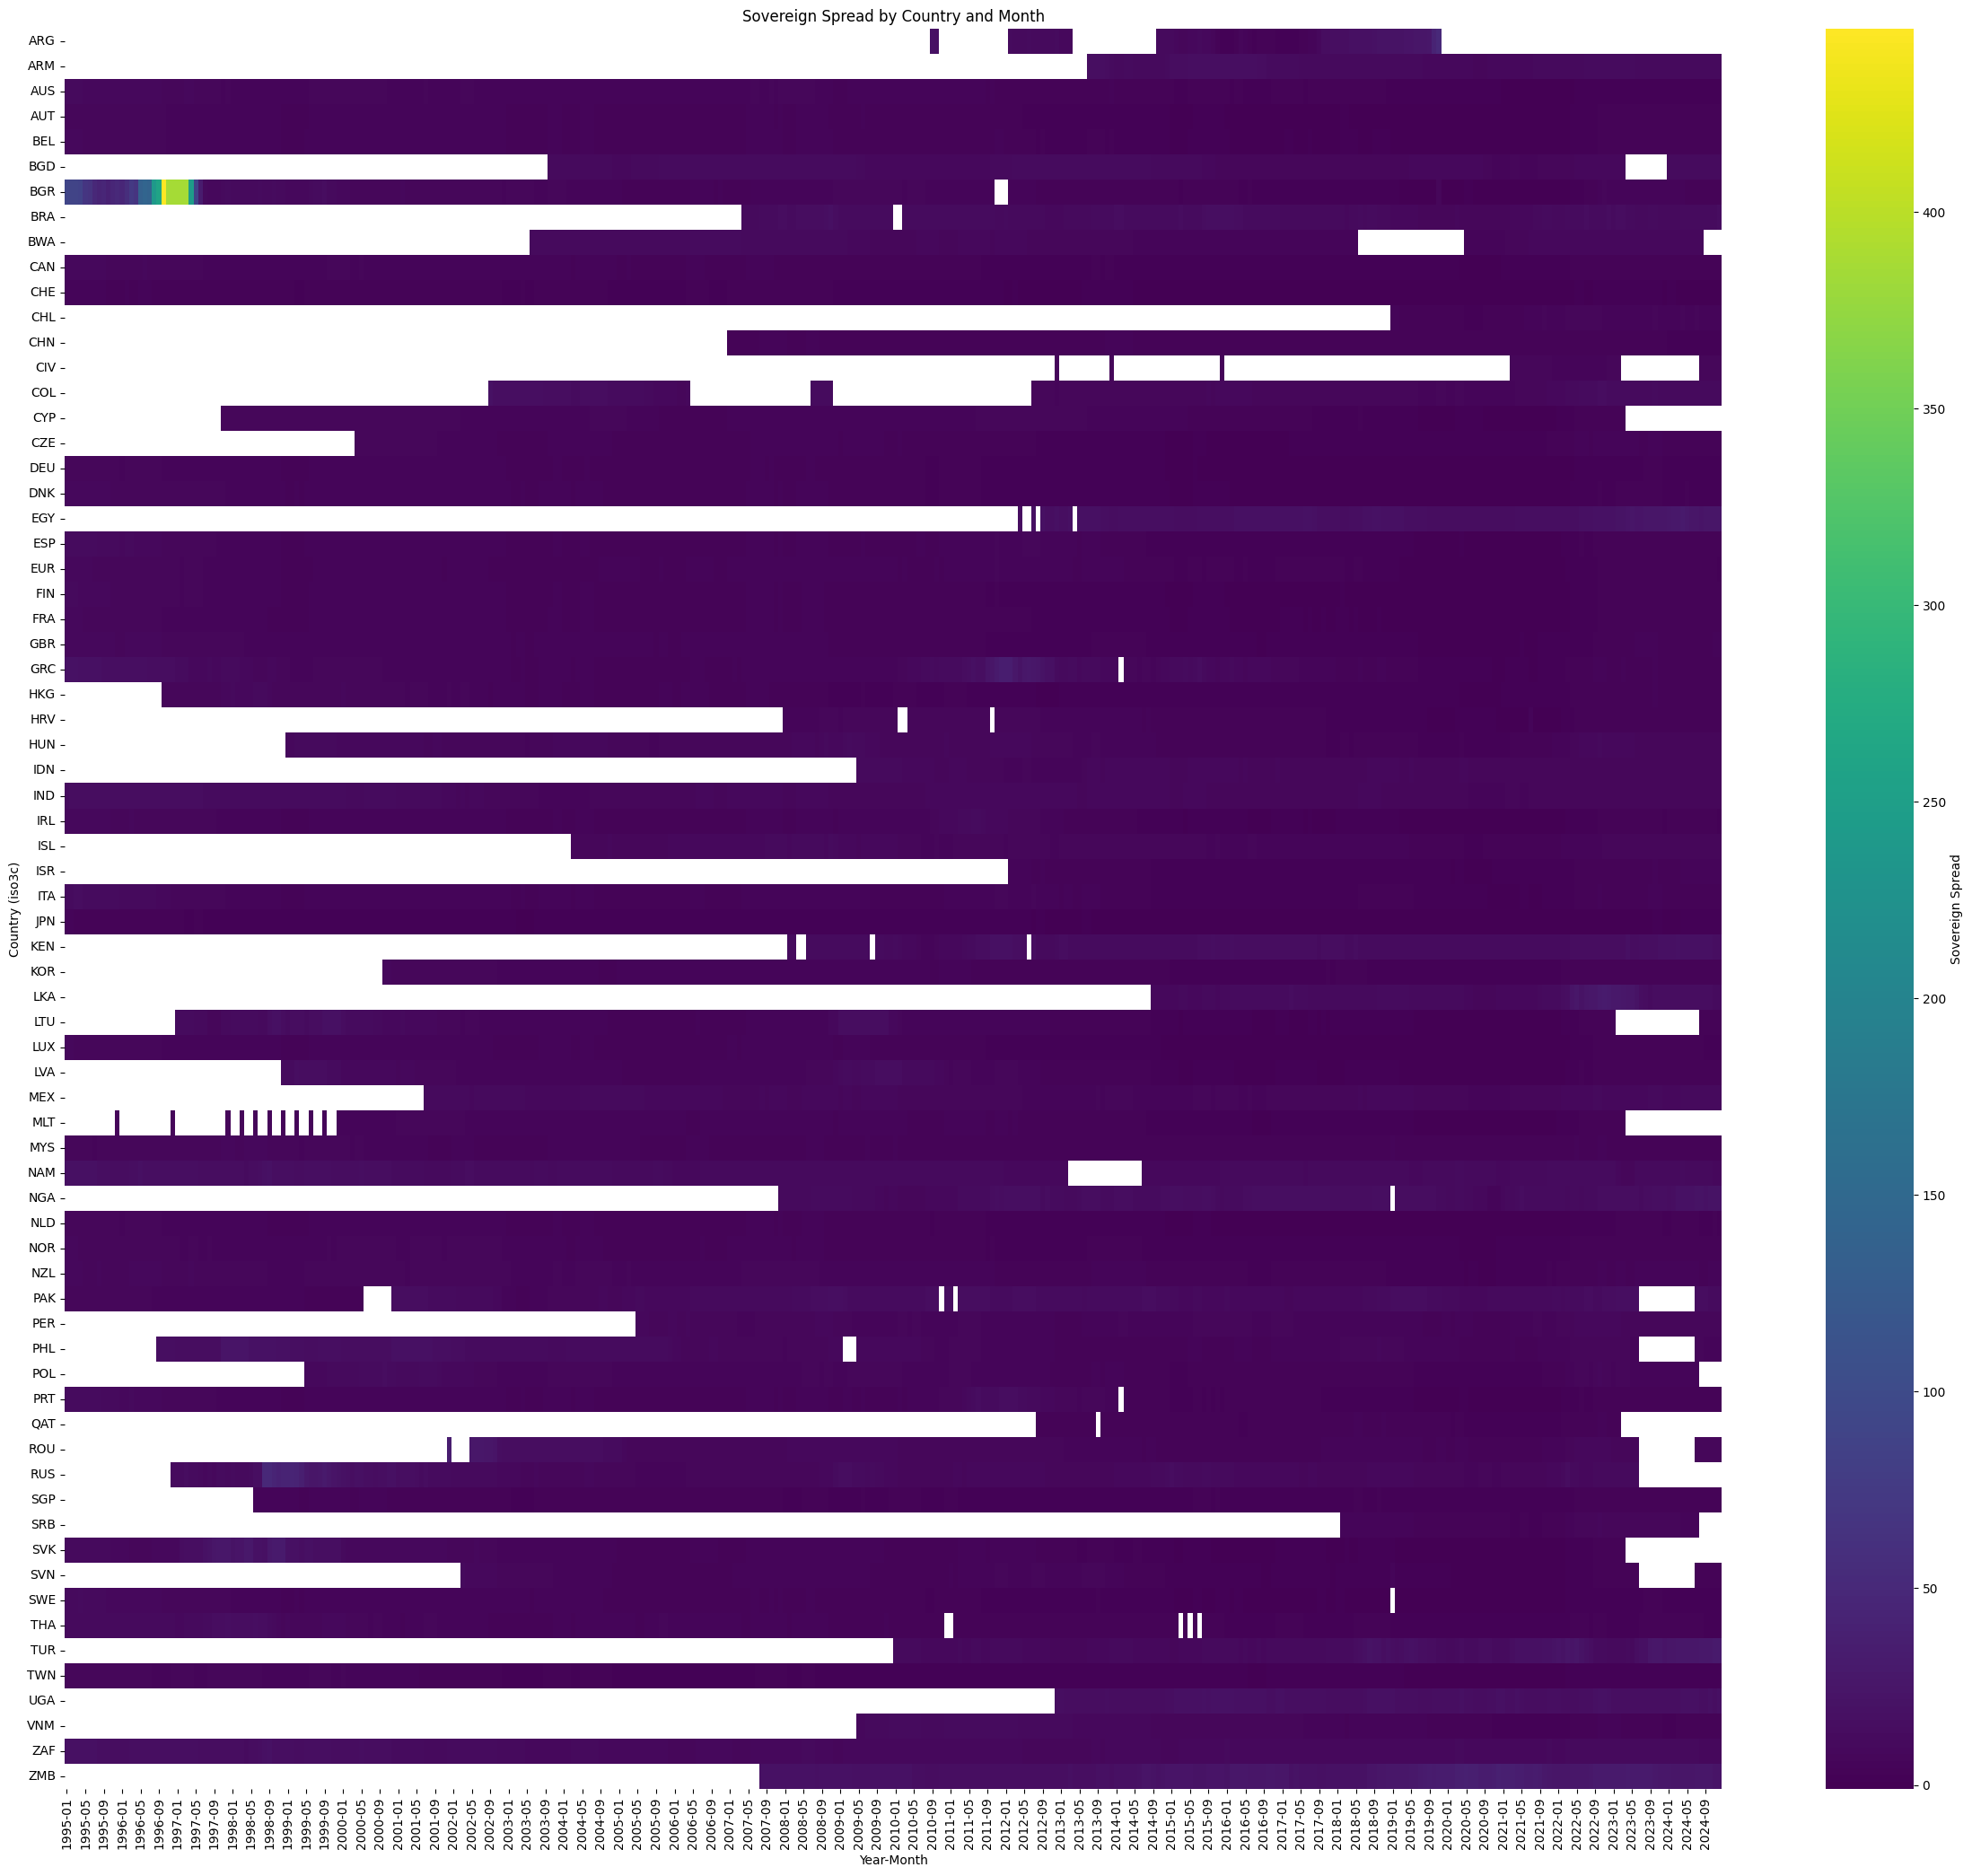

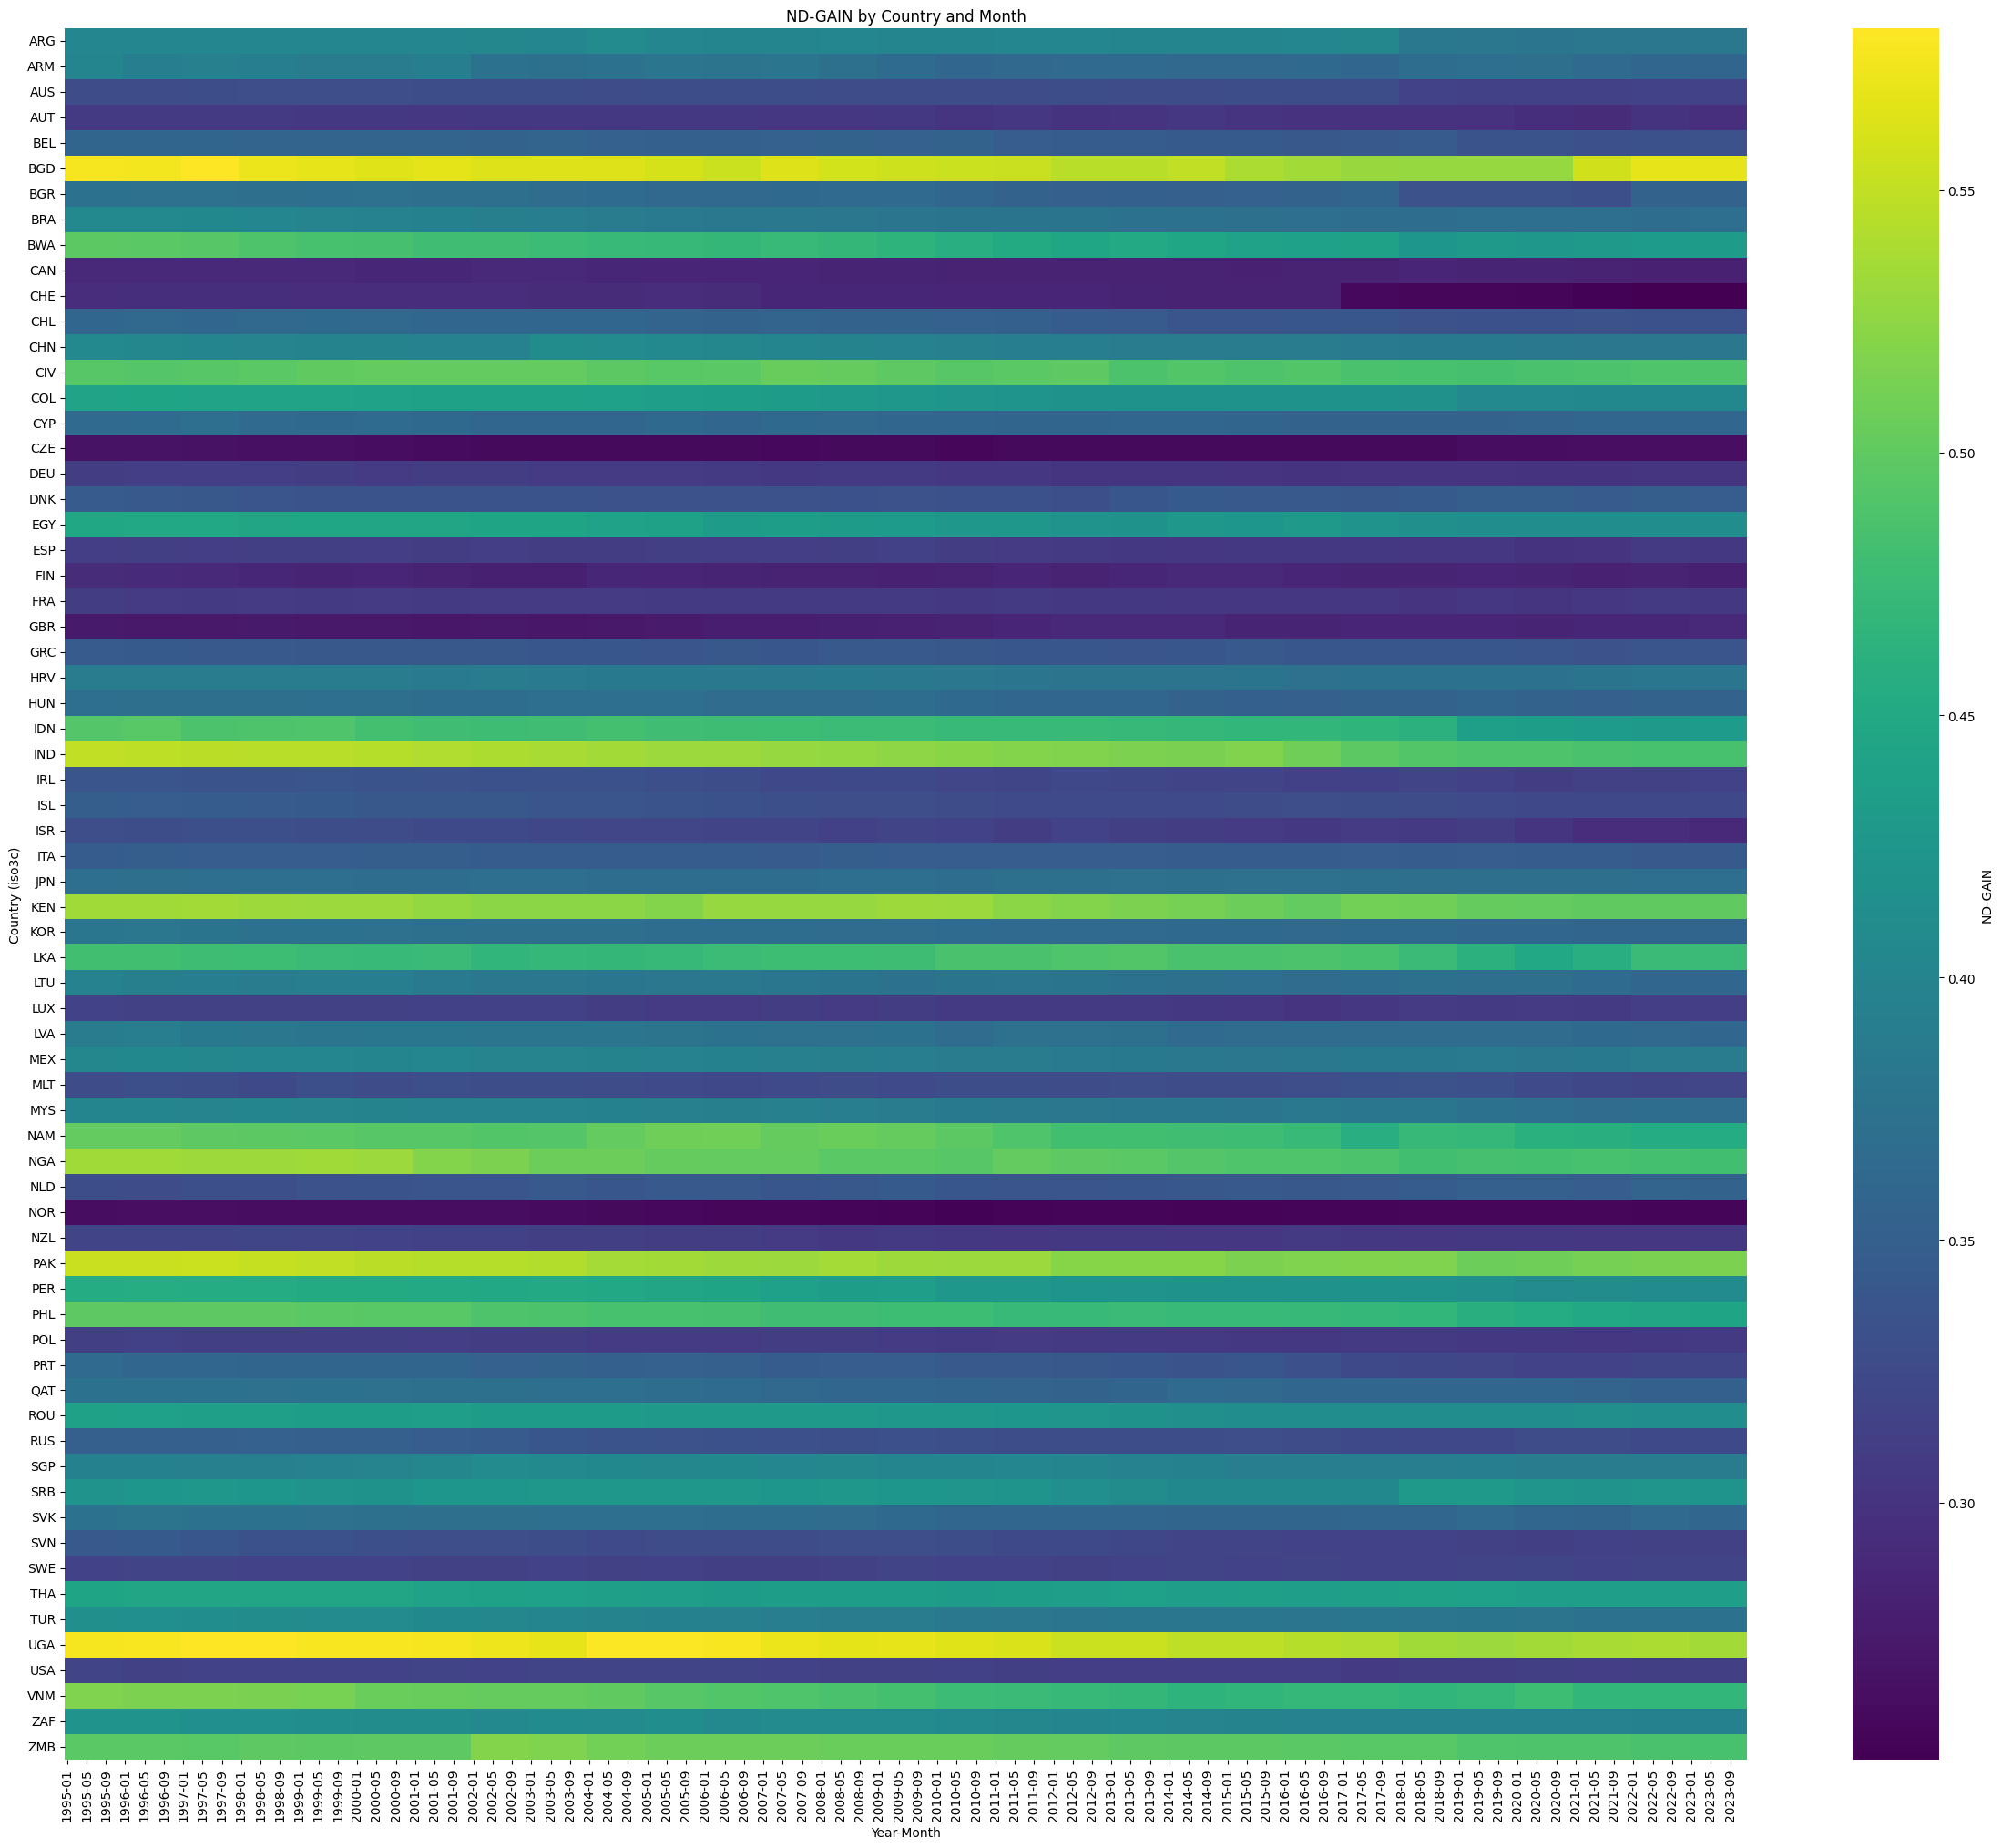

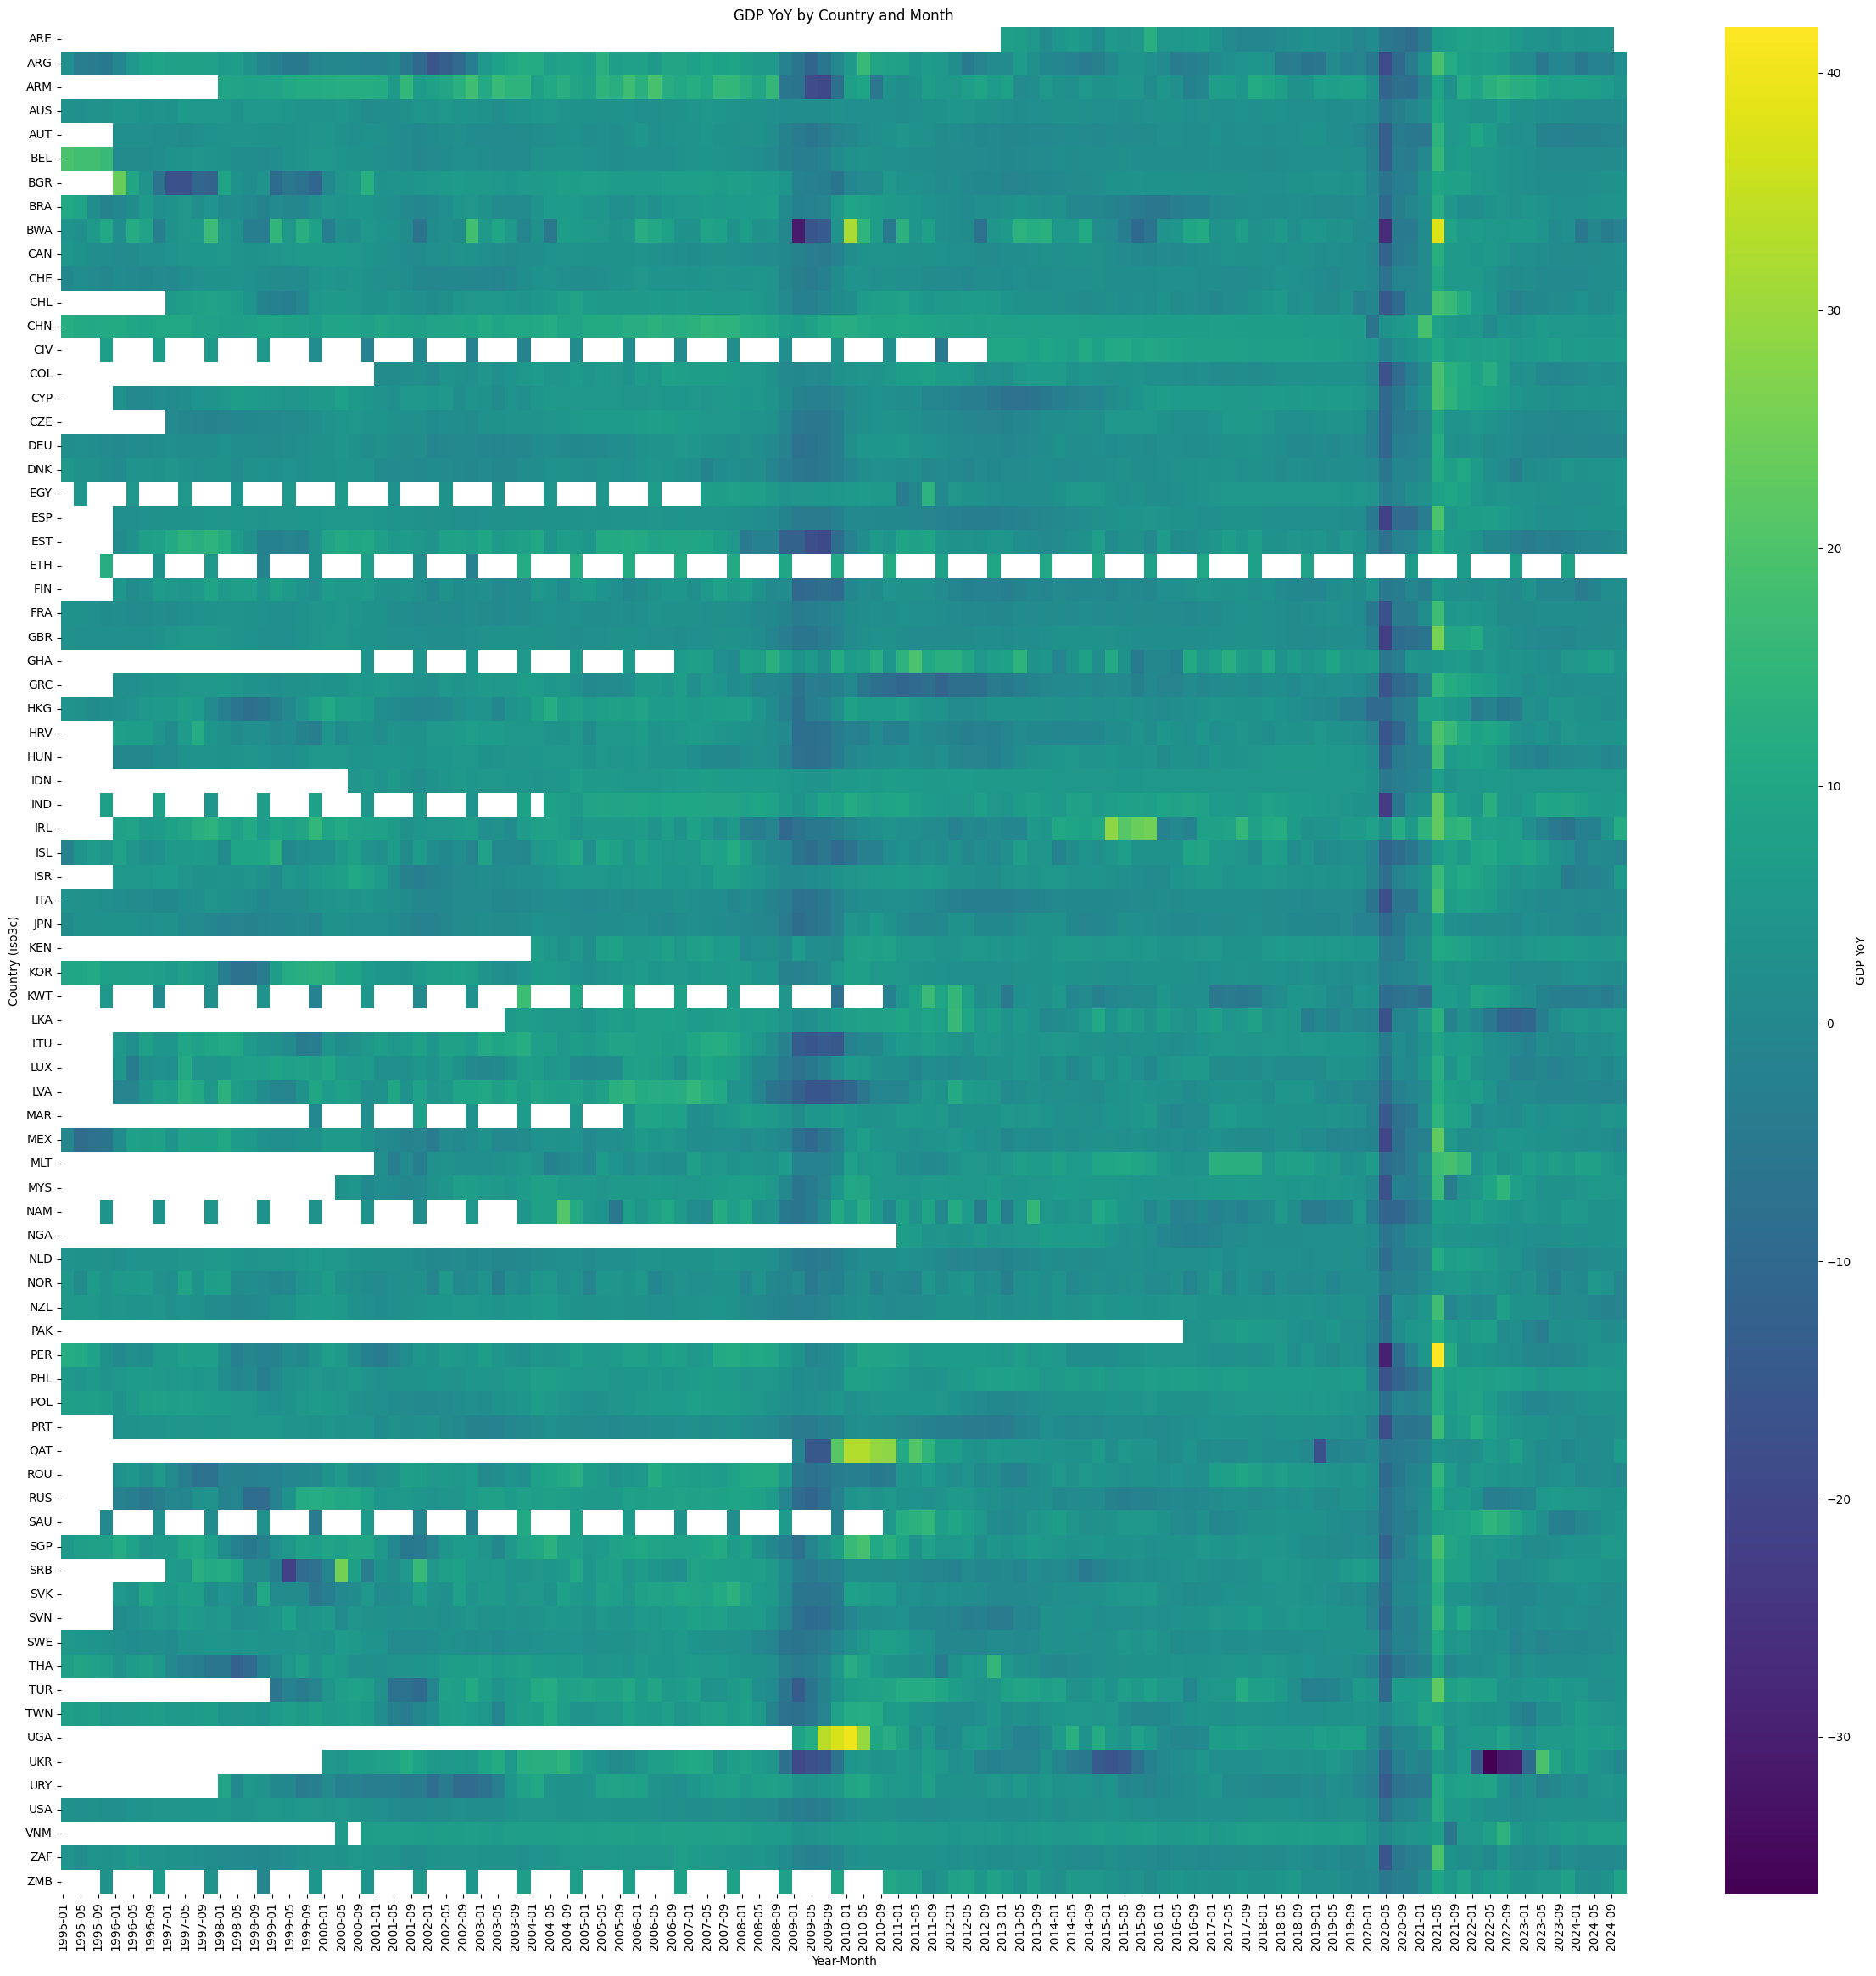

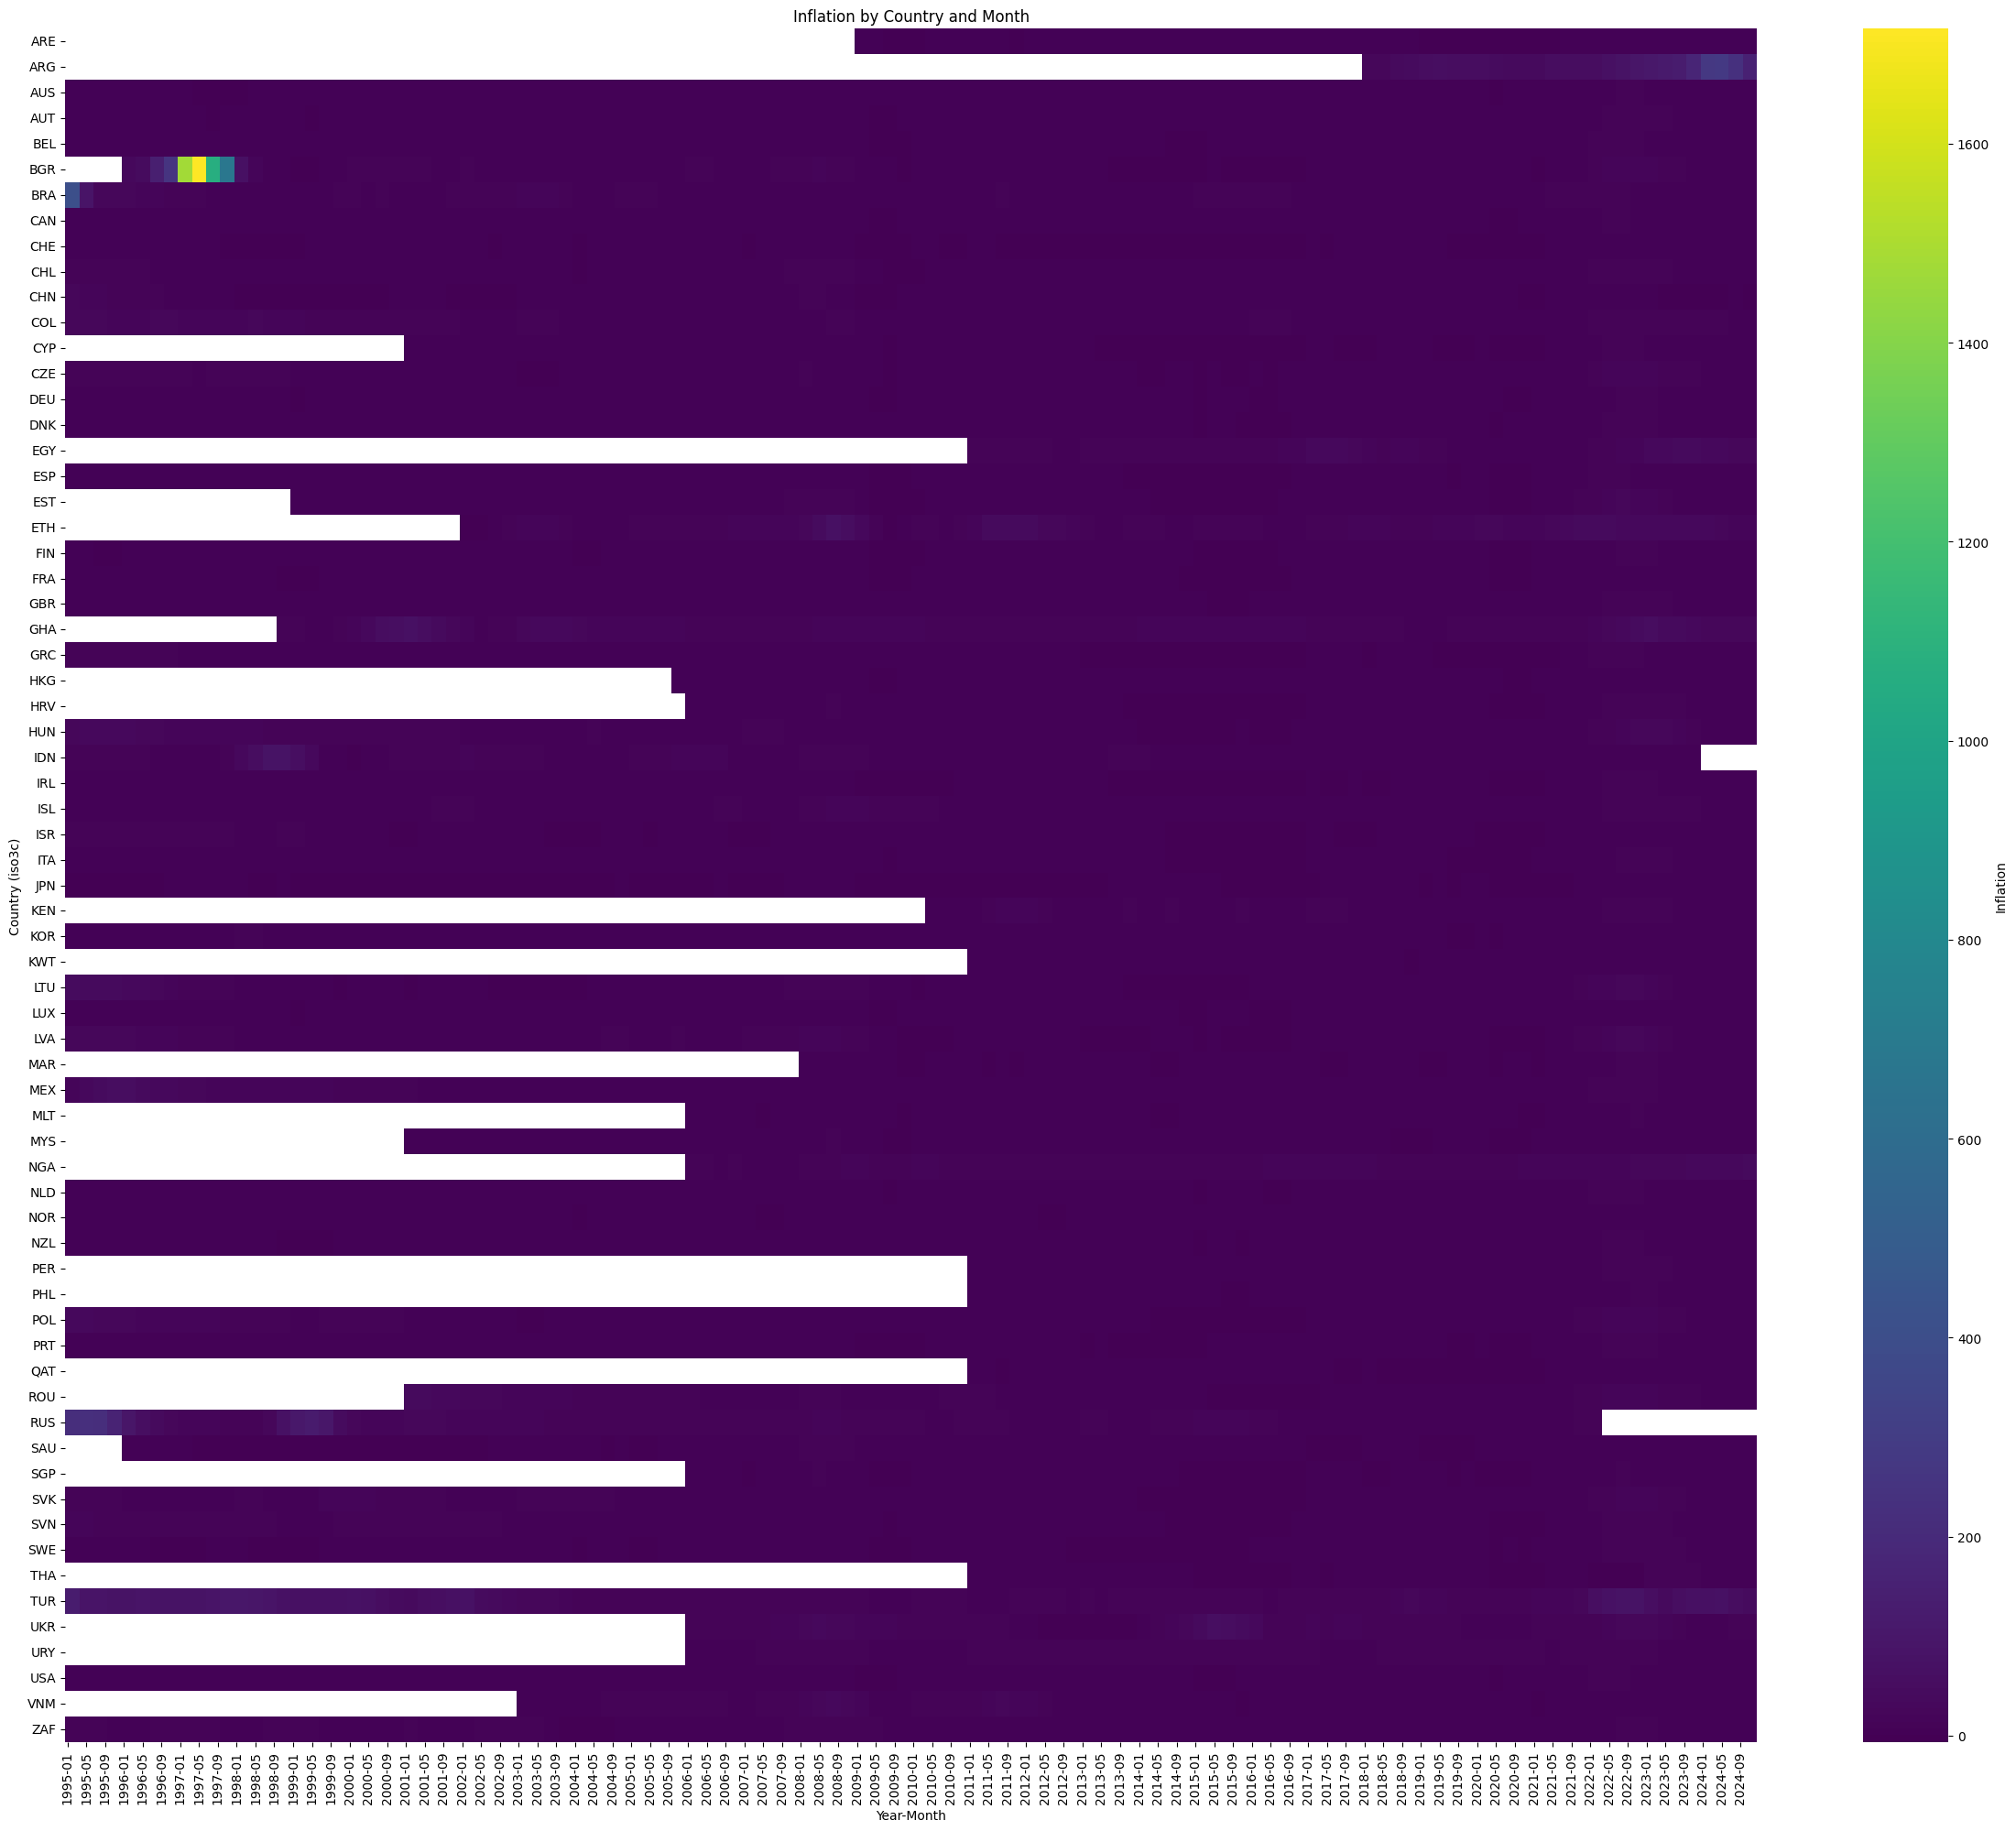

Column 'debt_gdp' not found in data, skipping Debt/GDP.


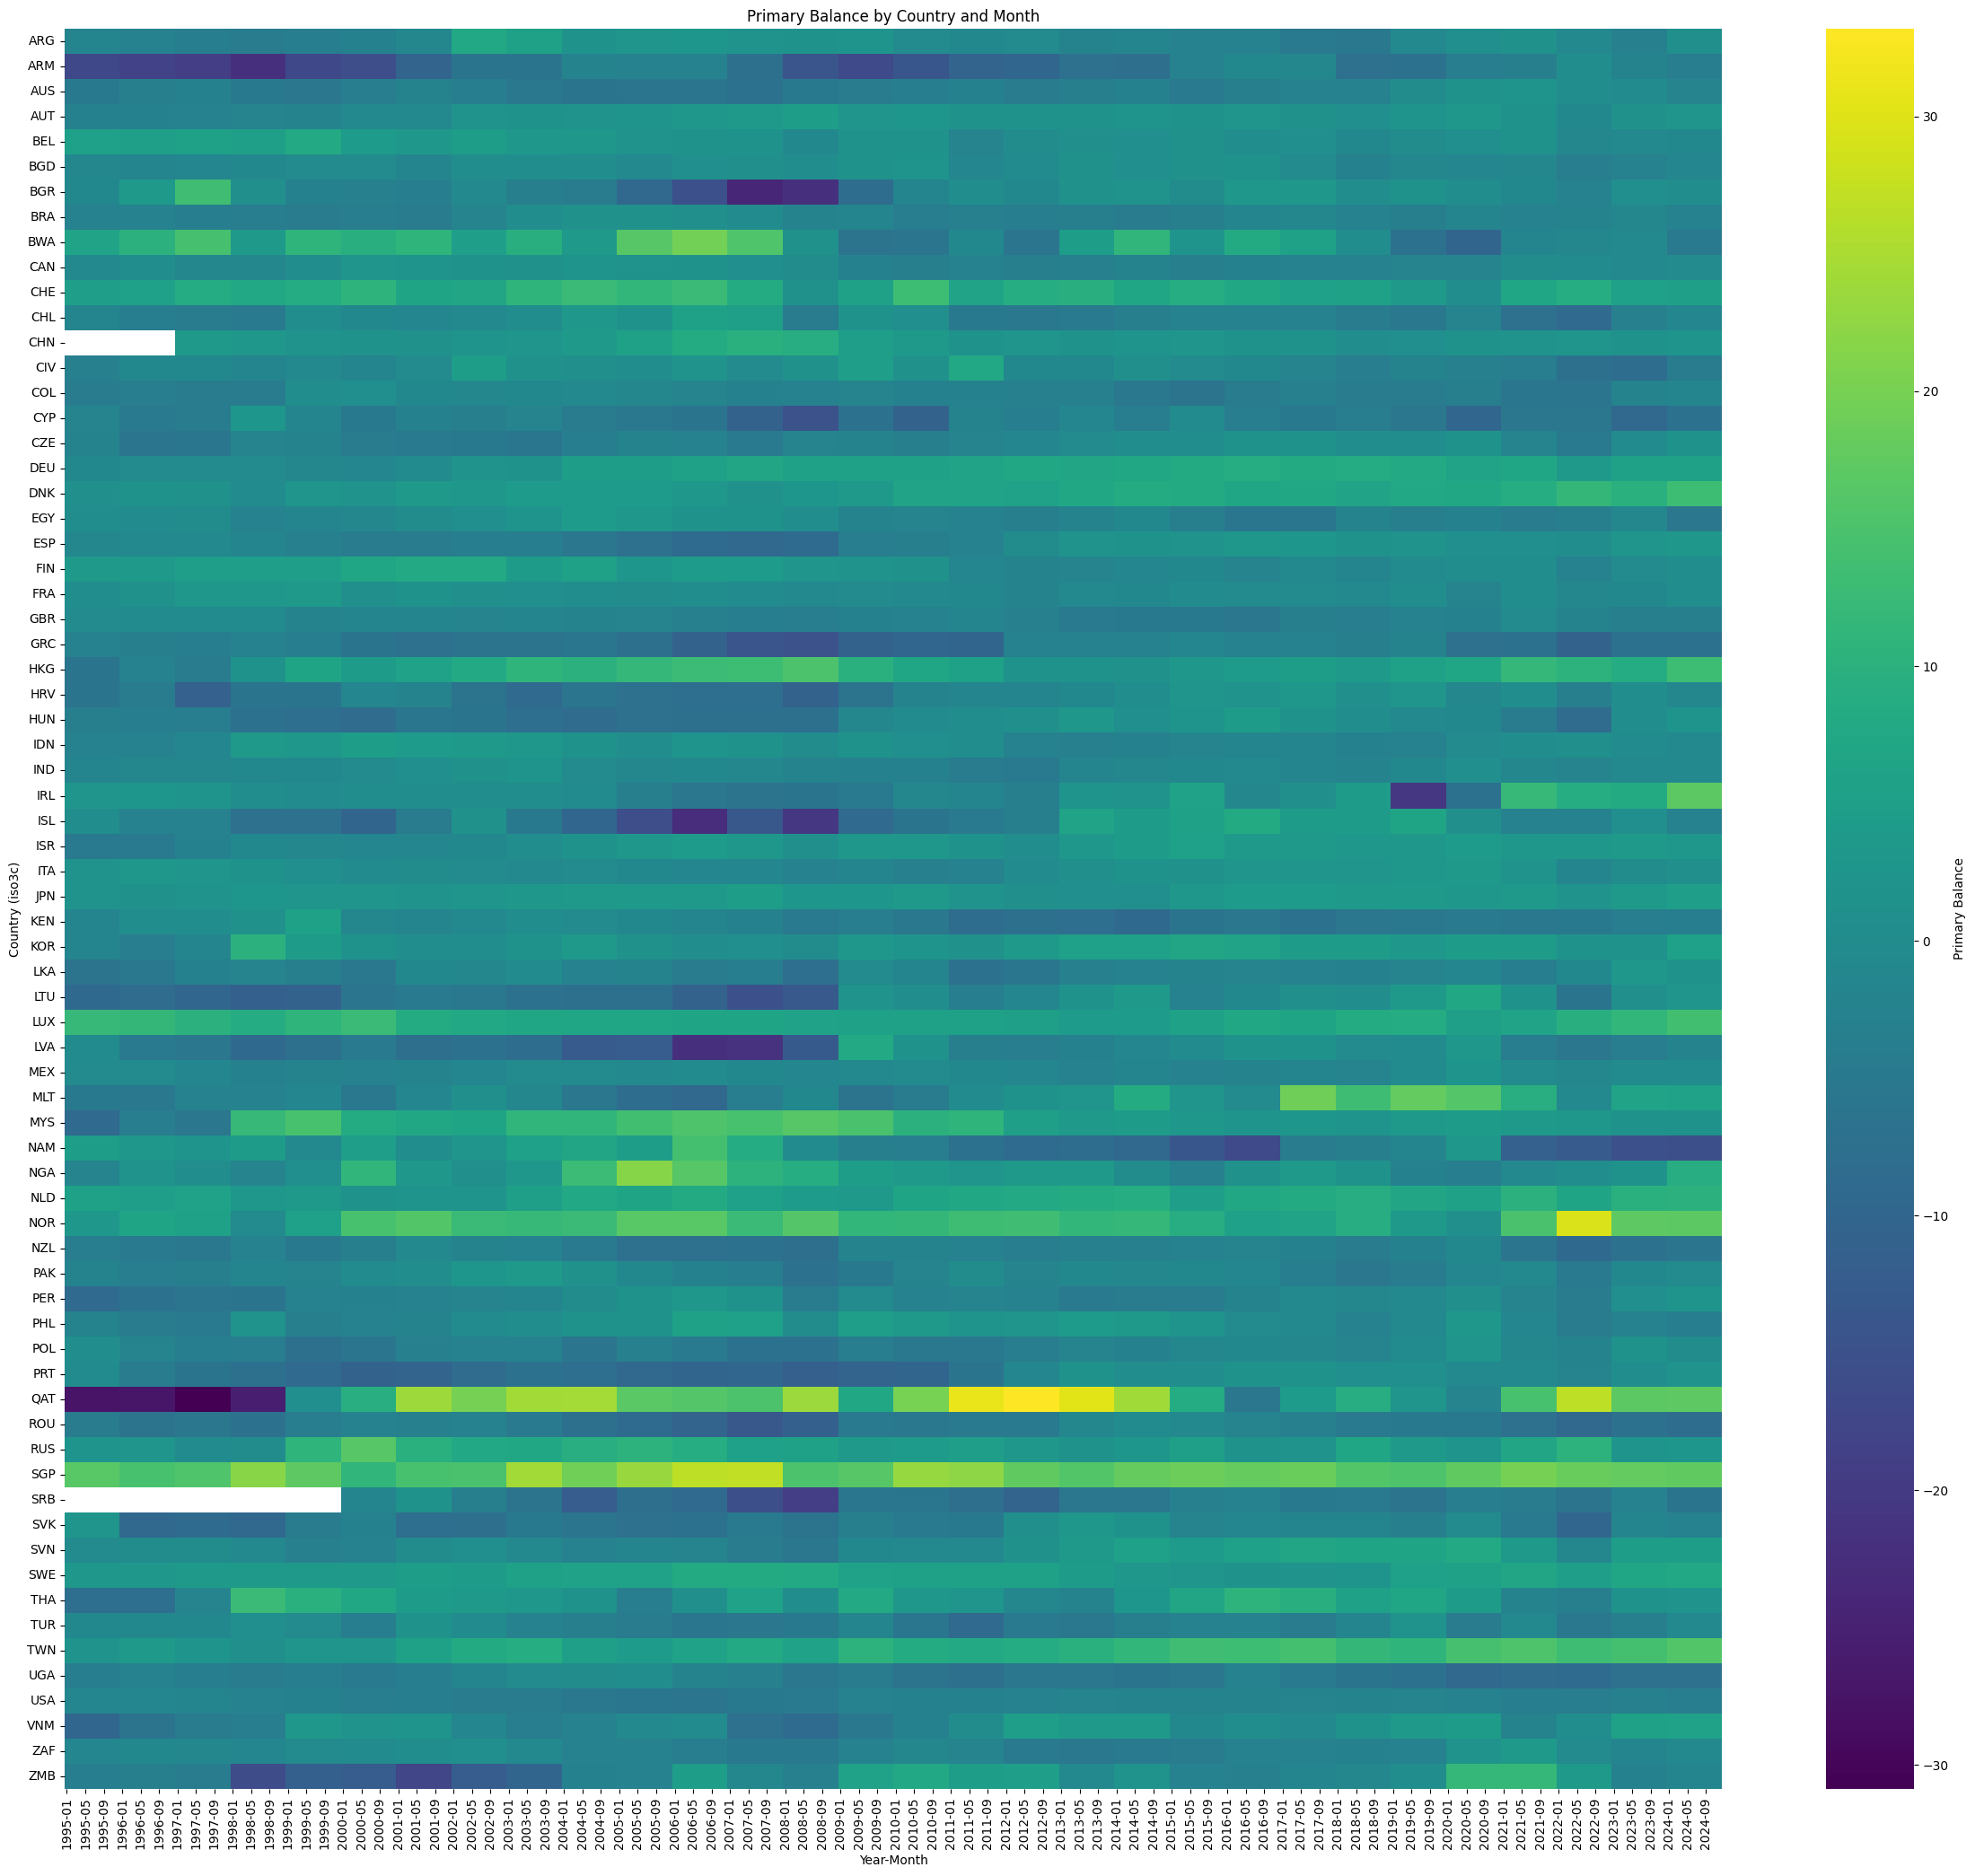

In [8]:
# matplotlib is not installed; skipping import and plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Define the key series and their column names in the dataset
key_series = {
    "Sovereign Spread": "yield_with_spread",
    "ND-GAIN": "vulnerability",
    "GDP YoY": "gdp_annual_growth_rate",
    "Inflation": "cpi_yoy",
    "Debt/GDP": "debt_gdp",
    "Primary Balance": "current_account_balance",
}

# Ensure 'date' is datetime and create a 'year_month' column for grouping
df_data['date'] = pd.to_datetime(df_data['date'])
df_data['year_month'] = df_data['date'].dt.to_period('M').astype(str)

# For each key series, plot a heatmap of value by country (rows) and month (columns)
for label, col in key_series.items():
    if col not in df_data.columns:
        print(f"Column '{col}' not found in data, skipping {label}.")
        continue
    # Pivot table: rows = country, columns = year_month, values = series
    heatmap_data = df_data.pivot_table(index='iso3c', columns='year_month', values=col)
    plt.figure(figsize=(min(24, 0.5*heatmap_data.shape[1]), max(6, 0.3*heatmap_data.shape[0])))
    sns.heatmap(heatmap_data, cmap='viridis', cbar_kws={'label': label}, 
                linewidths=0, linecolor='none', 
                mask=heatmap_data.isnull(), 
                square=False)
    plt.title(f"{label} by Country and Month")
    plt.xlabel("Year-Month")
    plt.ylabel("Country (iso3c)")
    plt.tight_layout()
    plt.show()

In [10]:
# Keeping only data from 1995-01-01 to 2024-12-31
from turtle import heading


df_data = df_data[df_data['date'] >= '1995-01-01']
df_data = df_data[df_data['date'] <= '2024-12-31']



In [11]:
# DROP OUTCOME SPREADS OR TREATMENT (VULNERABILITY)

# Drop rows where 'vulnerability' or 'sovereign_spread' is missing
df_data = df_data.dropna(subset=['vulnerability', 'sovereign_spread'])


In [12]:
# Print missingness for each column
missingness = df_data.isnull().mean().sort_values(ascending=False)
print("Missingness (fraction of missing values) by column:")
print(missingness)

# Identify and print columns with high missingness (e.g., > 0.3)
high_missing = missingness[missingness > 0.3]
if not high_missing.empty:
    print("\nColumns with high missingness (> 30%):")
    print(high_missing)
else:
    print("\nNo columns with high missingness (> 30%).")


Missingness (fraction of missing values) by column:
cpi_yoy         0.162185
wgi_rl          0.089688
wgi_cc          0.089688
wgi_va          0.089688
wgi_rq          0.089688
                  ...   
time_1990-06    0.000000
time_1990-07    0.000000
time_1990-08    0.000000
time_1990-09    0.000000
time_1998-12    0.000000
Length: 653, dtype: float64

No columns with high missingness (> 30%).


## Phase 5 - Exploratory Data Analysis

In [13]:

import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

# Summary statistics for sovereign spreads (global)
spread_stats = {
    "mean": df_data["sovereign_spread"].mean(),
    "median": df_data["sovereign_spread"].median(),
    "std": df_data["sovereign_spread"].std(),
    "skewness": skew(df_data["sovereign_spread"].dropna()),
    "kurtosis": kurtosis(df_data["sovereign_spread"].dropna())
}
print("Global Sovereign Spread Statistics:")
for k, v in spread_stats.items():
    print(f"{k.capitalize()}: {v:.3f}")

# Tail quantiles (1st, 5th, 95th, 99th percentiles)
quantiles = [0.01, 0.05, 0.95, 0.99]
spread_quantiles = df_data["sovereign_spread"].quantile(quantiles)
print("\nGlobal Sovereign Spread Tail Quantiles:")
for q, v in spread_quantiles.items():
    print(f"{int(q*100)}th percentile: {v:.3f}")

# By region (assuming 'region' column exists)
if "region" in df_data.columns:
    print("\nSovereign Spread Statistics by Region:")
    region_stats = df_data.groupby("region")["sovereign_spread"].agg(
        mean="mean",
        median="median",
        std="std"
    )
    # Compute skewness and kurtosis by region
    region_skew = df_data.groupby("region")["sovereign_spread"].apply(lambda x: skew(x.dropna()))
    region_kurt = df_data.groupby("region")["sovereign_spread"].apply(lambda x: kurtosis(x.dropna()))
    region_stats["skewness"] = region_skew
    region_stats["kurtosis"] = region_kurt
    print(region_stats.round(3))

    print("\nSovereign Spread Tail Quantiles by Region:")
    for region, group in df_data.groupby("region"):
        qtls = group["sovereign_spread"].quantile(quantiles)
        print(f"\nRegion: {region}")
        for q, v in qtls.items():
            print(f"  {int(q*100)}th percentile: {v:.3f}")
else:
    print("\nNo 'region' column found in data; skipping regional statistics.")

Global Sovereign Spread Statistics:
Mean: 2.609
Median: 0.876
Std: 7.346
Skewness: 29.250
Kurtosis: 1440.283

Global Sovereign Spread Tail Quantiles:
1th percentile: -2.872
5th percentile: -1.815
95th percentile: 11.182
99th percentile: 19.588

No 'region' column found in data; skipping regional statistics.


In [25]:
# Add regions (continents) based on iso3c country code

# Define a mapping from iso3c to continent/region
iso3c_to_region = {
    # North America
    "USA": "North America", "CAN": "North America", "MEX": "North America",
    # South America
    "BRA": "South America", "ARG": "South America", "CHL": "South America", "COL": "South America", "PER": "South America", "ECU": "South America", "URY": "South America", "BOL": "South America", "PRY": "South America", "VEN": "South America", "GUY": "South America", "SUR": "South America",
    # Europe
    "GBR": "Europe", "FRA": "Europe", "DEU": "Europe", "ITA": "Europe", "ESP": "Europe", "NLD": "Europe", "BEL": "Europe", "CHE": "Europe", "AUT": "Europe", "SWE": "Europe", "NOR": "Europe", "DNK": "Europe", "FIN": "Europe", "IRL": "Europe", "PRT": "Europe", "GRC": "Europe", "POL": "Europe", "CZE": "Europe", "HUN": "Europe", "SVK": "Europe", "SVN": "Europe", "EST": "Europe", "LVA": "Europe", "LTU": "Europe", "ROU": "Europe", "BGR": "Europe", "HRV": "Europe", "SRB": "Europe", "BIH": "Europe", "MNE": "Europe", "MKD": "Europe", "ALB": "Europe", "RUS": "Europe", "UKR": "Europe", "BLR": "Europe", "MDA": "Europe","CYP" : "Europe" , "ISL": "Europe" ,"LUX" : "Europe" , "MLT": "Europe",
    # Africa
    "ZAF": "Africa", "NGA": "Africa", "EGY": "Africa", "DZA": "Africa", "MAR": "Africa", "KEN": "Africa", "ETH": "Africa", "GHA": "Africa", "TUN": "Africa", "AGO": "Africa", "CMR": "Africa", "CIV": "Africa", "SEN": "Africa", "TZA": "Africa", "UGA": "Africa", "MOZ": "Africa", "SDN": "Africa", "ZMB": "Africa", "ZWE": "Africa", "BWA": "Africa", "NAM": "Africa", "MLI": "Africa", "NER": "Africa", "GAB": "Africa", "COG": "Africa", "COD": "Africa", "RWA": "Africa", "BDI": "Africa", "MWI": "Africa", "LSO": "Africa", "SWZ": "Africa", "GNB": "Africa", "GIN": "Africa", "SLE": "Africa", "LBR": "Africa", "TGO": "Africa", "BEN": "Africa", "BFA": "Africa", "CAF": "Africa", "TCD": "Africa", "SOM": "Africa", "DJI": "Africa", "ERI": "Africa", "SYC": "Africa", "CPV": "Africa", "STP": "Africa", "COM": "Africa", "EGY": "Africa", "LBY": "Africa", "SDN": "Africa", "SSD": "Africa", "TUN": "Africa", "MAR": "Africa", "ESH": "Africa", "DZA": "Africa", "MRT": "Africa", "MLI": "Africa", "NER": "Africa", "TCD": "Africa", "SEN": "Africa", "GMB": "Africa", "GNB": "Africa", "GIN": "Africa", "SLE": "Africa", "LBR": "Africa", "CIV": "Africa", "BFA": "Africa", "GHA": "Africa", "TGO": "Africa", "BEN": "Africa", "NGA": "Africa", "CMR": "Africa", "GNQ": "Africa", "GAB": "Africa", "COG": "Africa", "COD": "Africa", "UGA": "Africa", "RWA": "Africa", "BDI": "Africa", "TZA": "Africa", "KEN": "Africa", "SOM": "Africa", "ETH": "Africa", "ERI": "Africa", "DJI": "Africa", "SDN": "Africa", "SSD": "Africa", "AGO": "Africa", "ZMB": "Africa", "MWI": "Africa", "MOZ": "Africa", "ZWE": "Africa", "BWA": "Africa", "NAM": "Africa", "SWZ": "Africa", "LSO": "Africa", "ZAF": "Africa", "MDG": "Africa", "MUS": "Africa", "SYC": "Africa", "COM": "Africa", "CPV": "Africa", "STP": "Africa",
    # Asia
    "CHN": "Asia", "JPN": "Asia", "KOR": "Asia", "IND": "Asia", "IDN": "Asia", "THA": "Asia", "MYS": "Asia", "SGP": "Asia", "PHL": "Asia", "VNM": "Asia", "PAK": "Asia", "BGD": "Asia", "LKA": "Asia", "NPL": "Asia", "KAZ": "Asia", "UZB": "Asia", "TJK": "Asia", "KGZ": "Asia", "AFG": "Asia", "IRN": "Asia", "IRQ": "Asia", "SAU": "Asia", "ARE": "Asia", "QAT": "Asia", "KWT": "Asia", "OMN": "Asia", "BHR": "Asia", "ISR": "Asia", "JOR": "Asia", "LBN": "Asia", "SYR": "Asia", "YEM": "Asia", "TUR": "Asia", "GEO": "Asia", "ARM": "Asia", "AZE": "Asia", "MNG": "Asia", "TWN": "Asia", "HKG": "Asia", "MAC": "Asia", "PRK": "Asia", "TLS": "Asia", "MMR": "Asia", "KHM": "Asia", "LAO": "Asia", "BRN": "Asia", "MDV": "Asia",
    # Oceania
    "AUS": "Oceania", "NZL": "Oceania", "FJI": "Oceania", "PNG": "Oceania", "WSM": "Oceania", "TON": "Oceania", "VUT": "Oceania", "SLB": "Oceania", "KIR": "Oceania", "TUV": "Oceania", "NRU": "Oceania", "PLW": "Oceania", "MHL": "Oceania", "FSM": "Oceania",
    # Middle East (if you want to separate)
    "SAU": "Middle East", "ARE": "Middle East", "QAT": "Middle East", "KWT": "Middle East", "OMN": "Middle East", "BHR": "Middle East", "IRN": "Middle East", "IRQ": "Middle East", "ISR": "Middle East", "JOR": "Middle East", "LBN": "Middle East", "SYR": "Middle East", "YEM": "Middle East", "TUR": "Middle East",
    # Central America & Caribbean
    "CRI": "Central America", "PAN": "Central America", "SLV": "Central America", "HND": "Central America", "GTM": "Central America", "NIC": "Central America", "BLZ": "Central America",
    "CUB": "Caribbean", "DOM": "Caribbean", "HTI": "Caribbean", "JAM": "Caribbean", "TTO": "Caribbean", "BRB": "Caribbean", "BHS": "Caribbean", "GRD": "Caribbean", "LCA": "Caribbean", "VCT": "Caribbean", "ATG": "Caribbean", "KNA": "Caribbean", "DMA": "Caribbean", "SGP": "Asia"
}

# Assign region to each row based on iso3c
df_data["region"] = df_data["iso3c"].map(iso3c_to_region)
# If iso3c not found in mapping, assign "Other"
df_data["region"] = df_data["region"].fillna("Other")


In [16]:
# List all observations in region Europe with spread > 95th, >99th, and <1st percentiles

spread_95 = df_data["sovereign_spread"].quantile(0.95)
spread_99 = df_data["sovereign_spread"].quantile(0.99)
spread_01 = df_data["sovereign_spread"].quantile(0.01)

europe_df = df_data[df_data["region"] == "Europe"]

print("\nEurope: Observations with sovereign_spread > 95th percentile:")
display(europe_df[europe_df["sovereign_spread"] > spread_95])

print("\nEurope: Observations with sovereign_spread > 99th percentile:")
display(europe_df[europe_df["sovereign_spread"] > spread_99])

print("\nEurope: Observations with sovereign_spread < 1st percentile:")
display(europe_df[europe_df["sovereign_spread"] < spread_01])


Europe: Observations with sovereign_spread > 95th percentile:


,date,iso3c,yield_with_spread,sovereign_spread,cpi_yoy,gdp_annual_growth_rate,gdp_per_capita,gross gdp,debt_to_gdp,deficit_to_gdp,...,time_2025-06,time_2025-07,time_2025-08,time_2025-09,time_2025-10,time_2025-11,time_2025-12,sovereign_spread_lag1,sovereign_spread_lag2,region
5364,1995-01-01,BGR,90.86,83.080500,NaN,NaN,2284.824,18.992,NaN,2284.824,...,False,False,False,False,False,False,False,80.606190,77.005000,Europe
5365,1995-02-01,BGR,89.57,82.100526,NaN,NaN,2284.824,18.992,NaN,2284.824,...,False,False,False,False,False,False,False,83.080500,80.606190,Europe
5366,1995-03-01,BGR,89.52,82.315217,NaN,NaN,2284.824,18.992,NaN,2284.824,...,False,False,False,False,False,False,False,82.100526,83.080500,Europe
5367,1995-04-01,BGR,86.88,79.817368,NaN,NaN,2284.824,18.992,NaN,2284.824,...,False,False,False,False,False,False,False,82.315217,82.100526,Europe
5368,1995-05-01,BGR,67.77,61.137273,NaN,NaN,2284.824,18.992,NaN,2284.824,...,False,False,False,False,False,False,False,79.817368,82.315217,Europe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51953,1999-02-01,SVK,18.07,13.071053,6.879526,1.1,3873.180,20.890,47.0,3873.180,...,False,False,False,False,False,False,False,13.071053,13.777895,Europe
51954,1999-03-01,SVK,16.79,11.557391,6.879526,1.1,3873.180,20.890,47.0,-4.381,...,False,False,False,False,False,False,False,13.071053,13.071053,Europe
51955,1999-03-01,SVK,16.79,11.557391,6.879526,1.1,3873.180,20.890,47.0,3873.180,...,False,False,False,False,False,False,False,11.557391,13.071053,Europe
51958,1999-05-01,SVK,17.50,11.960500,6.970731,1.2,3873.180,20.890,47.0,-4.381,...,False,False,False,False,False,False,False,10.615455,10.615455,Europe



Europe: Observations with sovereign_spread > 99th percentile:


,date,iso3c,yield_with_spread,sovereign_spread,cpi_yoy,gdp_annual_growth_rate,gdp_per_capita,gross gdp,debt_to_gdp,deficit_to_gdp,...,time_2025-06,time_2025-07,time_2025-08,time_2025-09,time_2025-10,time_2025-11,time_2025-12,sovereign_spread_lag1,sovereign_spread_lag2,region
5364,1995-01-01,BGR,90.86,83.080500,NaN,NaN,2284.824,18.992,NaN,2284.824,...,False,False,False,False,False,False,False,80.606190,77.005000,Europe
5365,1995-02-01,BGR,89.57,82.100526,NaN,NaN,2284.824,18.992,NaN,2284.824,...,False,False,False,False,False,False,False,83.080500,80.606190,Europe
5366,1995-03-01,BGR,89.52,82.315217,NaN,NaN,2284.824,18.992,NaN,2284.824,...,False,False,False,False,False,False,False,82.100526,83.080500,Europe
5367,1995-04-01,BGR,86.88,79.817368,NaN,NaN,2284.824,18.992,NaN,2284.824,...,False,False,False,False,False,False,False,82.315217,82.100526,Europe
5368,1995-05-01,BGR,67.77,61.137273,NaN,NaN,2284.824,18.992,NaN,2284.824,...,False,False,False,False,False,False,False,79.817368,82.315217,Europe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51945,1998-10-01,SVK,28.85,24.320000,5.891146,10.2,4253.652,22.917,33.781,4253.652,...,False,False,False,False,False,False,False,24.320000,23.093333,Europe
51946,1998-11-01,SVK,28.85,24.022632,5.891146,10.2,4253.652,22.917,33.781,-3.287,...,False,False,False,False,False,False,False,24.320000,24.320000,Europe
51947,1998-11-01,SVK,28.85,24.022632,5.891146,10.2,4253.652,22.917,33.781,4253.652,...,False,False,False,False,False,False,False,24.022632,24.320000,Europe
51948,1998-12-01,SVK,28.85,24.205000,5.891146,10.2,4253.652,22.917,33.781,-3.287,...,False,False,False,False,False,False,False,24.022632,24.022632,Europe



Europe: Observations with sovereign_spread < 1st percentile:


,date,iso3c,yield_with_spread,sovereign_spread,cpi_yoy,gdp_annual_growth_rate,gdp_per_capita,gross gdp,debt_to_gdp,deficit_to_gdp,...,time_2025-06,time_2025-07,time_2025-08,time_2025-09,time_2025-10,time_2025-11,time_2025-12,sovereign_spread_lag1,sovereign_spread_lag2,region
8834,1997-02-01,CHE,3.458450,-2.961024,0.732588,0.5,41635.951,294.824,53.671,-1.488,...,False,False,False,False,False,False,False,-2.782439,-2.782439,Europe
8835,1997-02-01,CHE,3.458450,-2.961024,0.732588,0.5,41635.951,294.824,53.671,41635.951,...,False,False,False,False,False,False,False,-2.961024,-2.782439,Europe
8836,1997-03-01,CHE,3.581476,-3.113024,0.732588,0.5,41635.951,294.824,53.671,-1.488,...,False,False,False,False,False,False,False,-2.961024,-2.961024,Europe
8837,1997-03-01,CHE,3.581476,-3.113024,0.732588,0.5,41635.951,294.824,53.671,41635.951,...,False,False,False,False,False,False,False,-3.113024,-2.961024,Europe
8838,1997-04-01,CHE,3.711545,-3.173909,0.526815,2.0,41635.951,294.824,53.671,-1.488,...,False,False,False,False,False,False,False,-3.113024,-3.113024,Europe
8839,1997-04-01,CHE,3.711545,-3.173909,0.526815,2.0,41635.951,294.824,53.671,41635.951,...,False,False,False,False,False,False,False,-3.173909,-3.113024,Europe
8840,1997-05-01,CHE,3.511136,-3.199816,0.526815,2.0,41635.951,294.824,53.671,-1.488,...,False,False,False,False,False,False,False,-3.173909,-3.173909,Europe
8841,1997-05-01,CHE,3.511136,-3.199816,0.526815,2.0,41635.951,294.824,53.671,41635.951,...,False,False,False,False,False,False,False,-3.199816,-3.173909,Europe
8842,1997-06-01,CHE,3.384476,-3.109333,0.526815,2.0,41635.951,294.824,53.671,-1.488,...,False,False,False,False,False,False,False,-3.199816,-3.199816,Europe
8843,1997-06-01,CHE,3.384476,-3.109333,0.526815,2.0,41635.951,294.824,53.671,41635.951,...,False,False,False,False,False,False,False,-3.109333,-3.199816,Europe


In [17]:
import os

# Create output directory if it doesn't exist
output_dir = "region_extremes"
os.makedirs(output_dir, exist_ok=True)

regions = df_data["region"].unique()

for region in regions:
    region_df = df_data[df_data["region"] == region]
    # Skip if region_df is empty or sovereign_spread is all NaN
    if region_df.empty or region_df["sovereign_spread"].dropna().empty:
        continue
    spread_95 = region_df["sovereign_spread"].quantile(0.95)
    spread_99 = region_df["sovereign_spread"].quantile(0.99)
    extremes_df = region_df[
        (region_df["sovereign_spread"] > spread_95) |
        (region_df["sovereign_spread"] > spread_99)
    ].copy()
    # Add columns to indicate which threshold(s) are exceeded
    extremes_df["above_95th"] = extremes_df["sovereign_spread"] > spread_95
    extremes_df["above_99th"] = extremes_df["sovereign_spread"] > spread_99
    # Save to CSV
    region_filename = f"region_extremes_{region.replace(' ', '_')}.csv"
    extremes_df.to_csv(os.path.join(output_dir, region_filename), index=False)



<Figure size 1600x800 with 0 Axes>

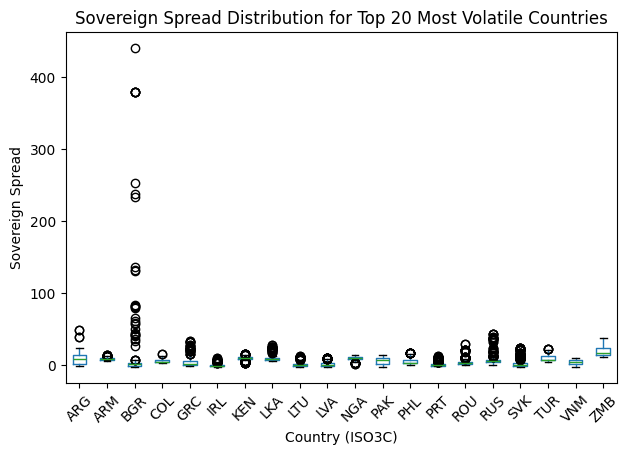

In [18]:
import matplotlib.pyplot as plt

# Calculate volatility (standard deviation) of sovereign_spread by country
volatility = df_data.groupby("iso3c")["sovereign_spread"].std().sort_values(ascending=False)

# Get top 20 countries by volatility
top20_countries = volatility.head(20).index.tolist()

# Filter data for these countries
top20_df = df_data[df_data["iso3c"].isin(top20_countries)]

plt.figure(figsize=(16, 8))
# Create a boxplot of sovereign_spread for each country
top20_df.boxplot(column="sovereign_spread", by="iso3c", grid=False, rot=45)
plt.title("Sovereign Spread Distribution for Top 20 Most Volatile Countries")
plt.suptitle("")
plt.xlabel("Country (ISO3C)")
plt.ylabel("Sovereign Spread")
plt.tight_layout()
plt.show()


In [28]:
import numpy as np
import pandas as pd

# Select only numeric columns for summary statistics
numeric_cols = df_data.select_dtypes(include=[np.number]).columns

# Compute summary statistics: mean, median, std. dev., count, min, max
summary_stats = pd.DataFrame({
    "Mean": df_data[numeric_cols].mean(),
    "Median": df_data[numeric_cols].median(),
    "Std. Dev.": df_data[numeric_cols].std(),
    "N": df_data[numeric_cols].count()
})

# Reorder columns for academic format
summary_stats = summary_stats[["Mean", "Median", "Std. Dev.", "N"]]

# Round for presentation
summary_stats = summary_stats.round(2)

# Rename index for academic style (Variable)
summary_stats.index.name = "Variable"

# Format table in academic journal style (e.g., with caption, no row numbers, professional look)
from IPython.display import display, HTML

# Display the table in the notebook with a caption
caption = '<caption style="caption-side:bottom; text-align:center; font-size:12px; padding:8px; font-style:italic;">Table 1: Descriptive Statistics of Main Variables<br></caption>'
table_html = summary_stats.to_html(
    classes='table table-striped',
    border=0,
    index=True,
    justify='center'
)
# Insert the caption just after the <table> tag
table_html = table_html.replace('<table border="0" class="dataframe table table-striped">', 
                               f'<table style="border-collapse:collapse; width:85%; font-size:13px; margin-left:auto; margin-right:auto;">{caption}')
display(HTML(table_html))
# Save the summary statistics table as a CSV file suitable for Overleaf (no index name row)
summary_stats.to_csv("summary_statistics_for_overleaf.csv", index=True, index_label=None)



,Mean,Median,Std. Dev.,N
Variable,,,,
yield_with_spread,5.98,4.84,7.44,35367
sovereign_spread,2.61,0.88,7.35,35367
cpi_yoy,4.16,2.39,26.79,29631
gdp_annual_growth_rate,2.97,3.00,4.26,33572
gdp_per_capita,25212.60,18506.08,23756.43,35367
gross gdp,780.75,279.30,1571.39,35367
debt_to_gdp,58.62,50.83,36.11,35246
deficit_to_gdp,12824.59,802.01,21152.10,35367
current_account_balance,0.27,-0.32,5.95,35367


In [ ]:
# Compute Pearson correlation matrix for selected variables

selected_vars = [
    "sovereign_spread_lag1",
    "cpi_yoy",
    "gdp_annual_growth_rate",
    "gdp_per_capita",
    "gross gdp",
    "debt_to_gdp",
    "deficit_to_gdp",
    "current_account_balance",
    "vulnerability",
    "wgi_cc",
    "wgi_ge",
    "wgi_pv",
    "wgi_rl",
    "wgi_rq",
    "wgi_va"
]

# Filter dataframe to only include selected variables and drop rows with all NaNs in these columns
corr_df = df_data[selected_vars].copy()

# Compute Pearson correlation matrix
pearson_corr = corr_df.corr(method='pearson')

# Display the correlation matrix in the notebook
display(HTML(
    pearson_corr.round(2).to_html(
        classes='table table-striped',
        border=0,
        index=True,
        justify='center',
        na_rep='',
        float_format="%.2f"
    )
))


# Optionally, save the correlation matrix to CSV for Overleaf
pearson_corr.round(2).to_csv("pearson_correlation_matrix.csv")

,sovereign_spread_lag1,cpi_yoy,gdp_annual_growth_rate,gdp_per_capita,gross gdp,debt_to_gdp,deficit_to_gdp,current_account_balance,vulnerability,wgi_cc,wgi_ge,wgi_pv,wgi_rl,wgi_rq,wgi_va
sovereign_spread_lag1,1.00,0.62,-0.05,-0.33,-0.11,-0.09,-0.19,-0.11,0.36,-0.45,-0.52,-0.41,-0.48,-0.52,-0.41
cpi_yoy,0.62,1.00,-0.07,-0.07,-0.03,-0.12,-0.04,0.01,0.06,-0.31,-0.37,-0.33,-0.34,-0.36,-0.28
gdp_annual_growth_rate,-0.05,-0.07,1.00,-0.13,-0.01,-0.19,-0.07,-0.02,0.18,-0.14,-0.13,-0.12,-0.15,-0.14,-0.18
gdp_per_capita,-0.33,-0.07,-0.13,1.00,0.07,0.11,0.57,0.39,-0.64,0.78,0.76,0.59,0.77,0.74,0.62
gross gdp,-0.11,-0.03,-0.01,0.07,1.00,0.28,0.03,0.08,-0.09,0.03,0.07,-0.06,0.01,-0.03,-0.14
debt_to_gdp,-0.09,-0.12,-0.19,0.11,0.28,1.00,0.08,-0.00,-0.12,0.14,0.17,0.11,0.18,0.10,0.17
deficit_to_gdp,-0.19,-0.04,-0.07,0.57,0.03,0.08,1.00,0.25,-0.35,0.45,0.44,0.34,0.44,0.43,0.34
current_account_balance,-0.11,0.01,-0.02,0.39,0.08,-0.00,0.25,1.00,-0.16,0.27,0.30,0.17,0.23,0.19,0.02
vulnerability,0.36,0.06,0.18,-0.64,-0.09,-0.12,-0.35,-0.16,1.00,-0.73,-0.77,-0.68,-0.76,-0.80,-0.70
wgi_cc,-0.45,-0.31,-0.14,0.78,0.03,0.14,0.45,0.27,-0.73,1.00,0.95,0.80,0.97,0.93,0.82


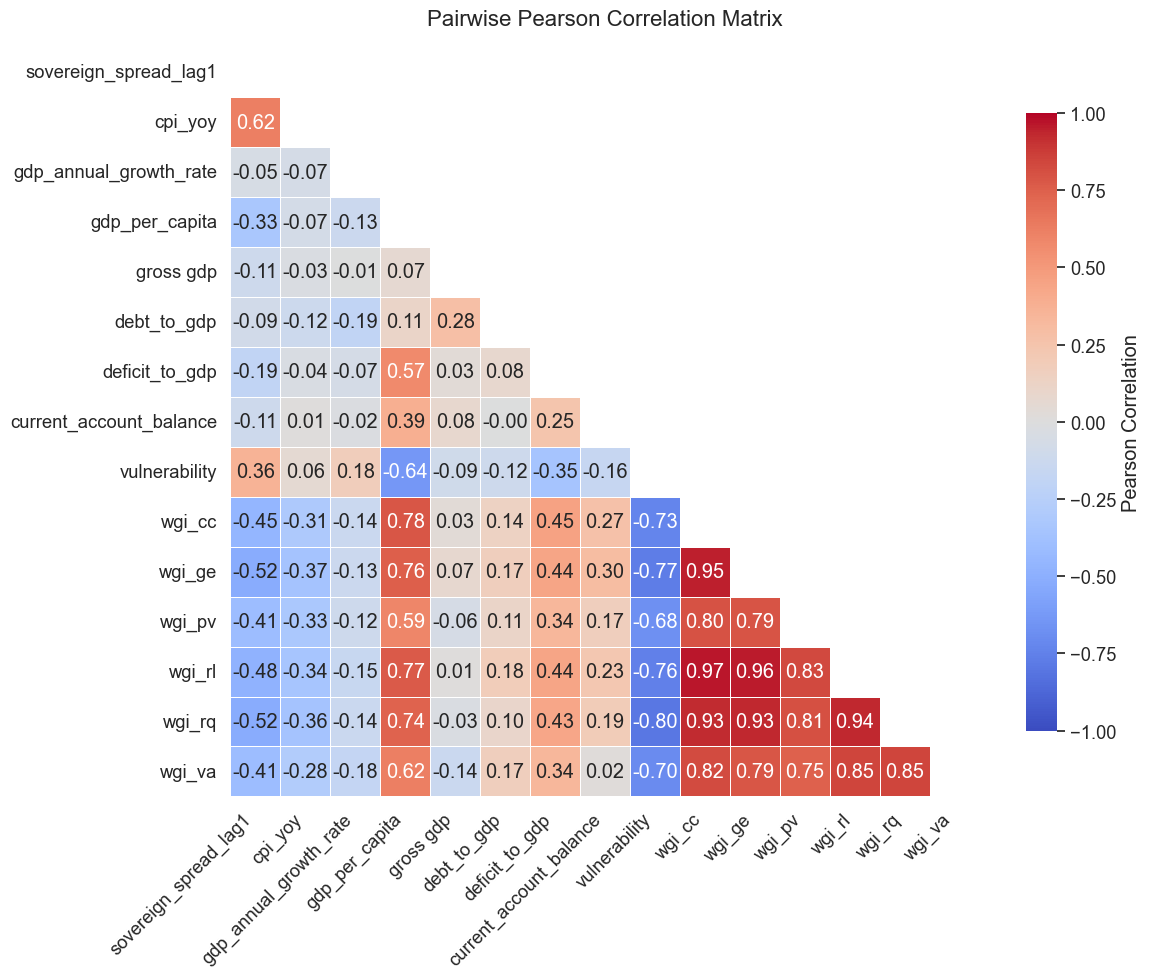

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Generate a mask for the upper triangle (optional, for cleaner look)
mask = np.triu(np.ones_like(pearson_corr, dtype=bool))

# Create a custom colormap that sets masked (empty) cells to white
from matplotlib.colors import ListedColormap
import matplotlib as mpl

# Use the default coolwarm colormap for data, but set bad (masked) values to white
cmap = plt.get_cmap("coolwarm").copy()
cmap.set_bad(color='white')

sns.set(font_scale=1.2)
ax = sns.heatmap(
    pearson_corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap=cmap,
    vmin=-1, vmax=1,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8, "label": "Pearson Correlation"},
    square=True
)

# Set title and adjust layout for academic standards
plt.title("Pairwise Pearson Correlation Matrix", fontsize=16, pad=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
# Save the pairwise Pearson correlation matrix heatmap as a high-resolution PNG and PDF
plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    pearson_corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap=cmap,
    vmin=-1, vmax=1,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8, "label": "Pearson Correlation"},
    square=True
)
plt.title("Pairwise Pearson Correlation Matrix", fontsize=16, pad=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("pearson_correlation_matrix.png", dpi=300, bbox_inches='tight')
plt.savefig("pearson_correlation_matrix.pdf", bbox_inches='tight')
plt.close()



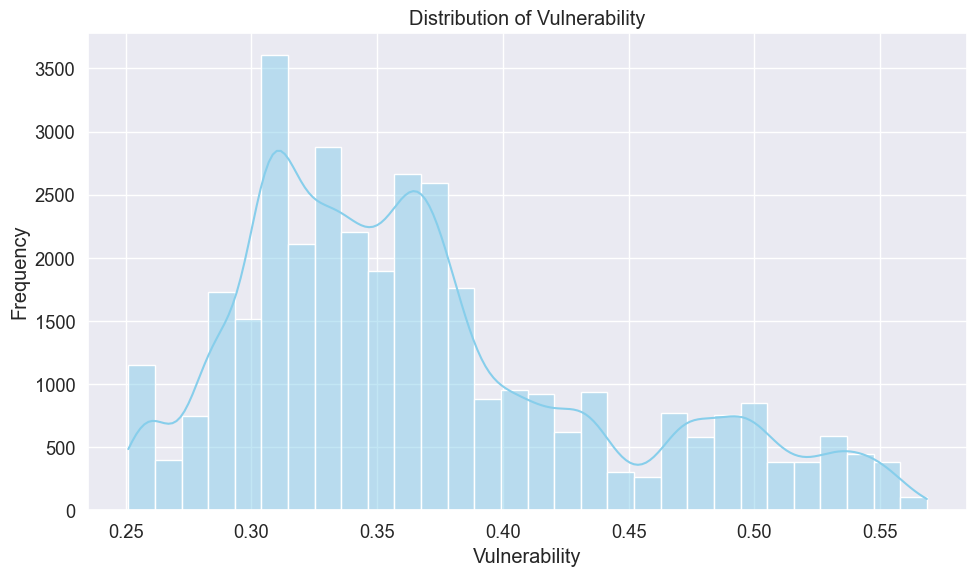

In [36]:
plt.figure(figsize=(10, 6))
sns.histplot(df_data['vulnerability'].dropna(), bins=30, kde=True, color='skyblue')
plt.title('Distribution of Vulnerability')
plt.xlabel('Vulnerability')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


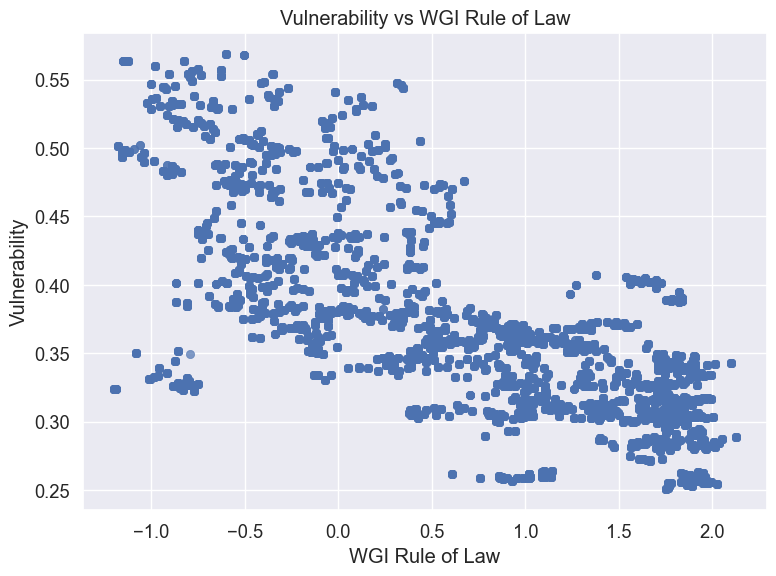

Pearson correlation (Vulnerability vs WGI Rule of Law): -0.756 (p=0)


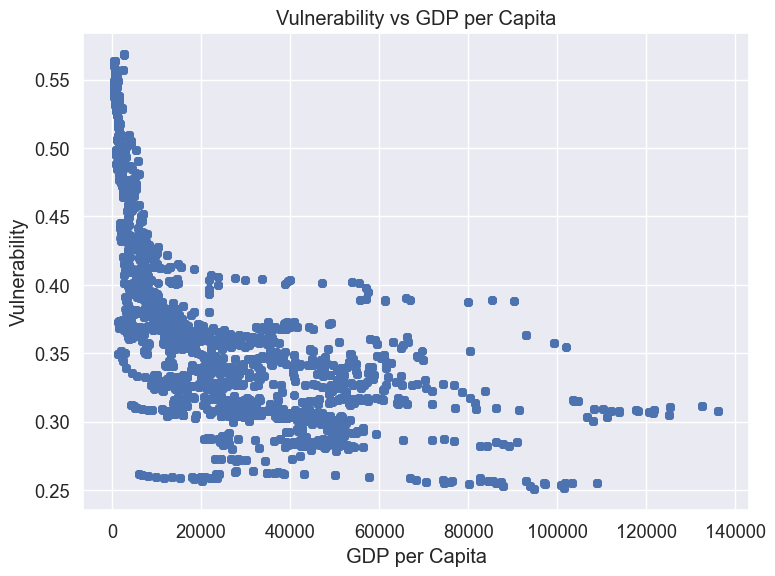

Pearson correlation (Vulnerability vs GDP per Capita): -0.638 (p=0)


In [38]:
# Scatterplots and pairwise correlations: vulnerability vs wgi_rl, vulnerability vs gdp_per_capita

import scipy.stats as stats

# Scatterplot: Vulnerability vs WGI Rule of Law
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_data,
    x='wgi_rl',
    y='vulnerability',
    alpha=0.7,
    edgecolor=None
)
plt.title('Vulnerability vs WGI Rule of Law')
plt.xlabel('WGI Rule of Law')
plt.ylabel('Vulnerability')
plt.tight_layout()
plt.show()

# Pearson correlation
corr_vuln_wgi_rl, pval_vuln_wgi_rl = stats.pearsonr(
    df_data['wgi_rl'].dropna(),
    df_data.loc[df_data['wgi_rl'].notna(), 'vulnerability']
)
print(f"Pearson correlation (Vulnerability vs WGI Rule of Law): {corr_vuln_wgi_rl:.3f} (p={pval_vuln_wgi_rl:.3g})")

# Scatterplot: Vulnerability vs GDP per Capita
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_data,
    x='gdp_per_capita',
    y='vulnerability',
    alpha=0.7,
    edgecolor=None
)
plt.title('Vulnerability vs GDP per Capita')
plt.xlabel('GDP per Capita')
plt.ylabel('Vulnerability')
plt.tight_layout()
plt.show()

# Pearson correlation
corr_vuln_gdp, pval_vuln_gdp = stats.pearsonr(
    df_data['gdp_per_capita'].dropna(),
    df_data.loc[df_data['gdp_per_capita'].notna(), 'vulnerability']
)
print(f"Pearson correlation (Vulnerability vs GDP per Capita): {corr_vuln_gdp:.3f} (p={pval_vuln_gdp:.3g})")


In [ ]:
# Collinearity diagnostic: VIF analysis after residualizing covariates on fixed effects

import pandas as pd D
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Define covariate set
covariates = [
    'sovereign_spread_lag1', 'cpi_yoy', 'gdp_annual_growth_rate', 'gdp_per_capita',
    'gross gdp', 'debt_to_gdp', 'deficit_to_gdp', 'current_account_balance',
    'vulnerability', 'wgi_cc', 'wgi_ge', 'wgi_pv', 'wgi_rl', 'wgi_rq', 'wgi_va'
]

# Drop rows with missing values in covariates and fixed effects
fixed_effects = ['iso3c', 'date']
vif_df = df_data[covariates + fixed_effects].dropna().copy()

# Ensure all covariates are numeric
for col in covariates:
    vif_df[col] = pd.to_numeric(vif_df[col], errors='coerce')

# Residualize each covariate on country and time fixed effects
residualized = pd.DataFrame(index=vif_df.index)
for var in covariates:
    # Create dummies for country and time
    dummies_country = pd.get_dummies(vif_df['iso3c'], prefix='country', drop_first=True)
    dummies_time = pd.get_dummies(vif_df['date'], prefix='time', drop_first=True)
    X_fe = pd.concat([dummies_country, dummies_time], axis=1)
    X_fe = sm.add_constant(X_fe)
    y = pd.to_numeric(vif_df[var], errors='coerce')
    # Ensure y and X_fe are float64
    y = y.astype(float)
    X_fe = X_fe.astype(float)
    model = sm.OLS(y, X_fe).fit()
    residualized[var] = model.resid

# Compute VIF on residualized covariates
# Ensure residualized is float64 and has no object columns
residualized = residualized.astype(float)
vif_table = pd.DataFrame()
vif_table['variable'] = covariates
vif_table['VIF'] = [
    variance_inflation_factor(residualized.values, i)
    for i in range(residualized.shape[1])
]
print("VIF after residualizing on fixed effects:")
print(vif_table)

VIF after residualizing on fixed effects:
                   variable       VIF
0     sovereign_spread_lag1  1.358125
1                   cpi_yoy  1.184415
2    gdp_annual_growth_rate  1.134206
3            gdp_per_capita  1.314690
4                 gross gdp  1.091557
5               debt_to_gdp  1.271079
6            deficit_to_gdp  1.029191
7   current_account_balance  1.121737
8             vulnerability  1.144055
9                    wgi_cc  1.810249
10                   wgi_ge  2.042567
11                   wgi_pv  1.179889
12                   wgi_rl  2.130952
13                   wgi_rq  1.729315
14                   wgi_va  1.424435


## Vulnerability overtime plot


Mean vulnerability across all countries over time:
date
1995-01-01    0.352980
1995-02-01    0.352980
1995-03-01    0.352980
1995-04-01    0.352980
1995-05-01    0.352980
                ...   
2023-08-01    0.364458
2023-09-01    0.364458
2023-10-01    0.364458
2023-11-01    0.364458
2023-12-01    0.364458
Name: vulnerability, Length: 348, dtype: float64


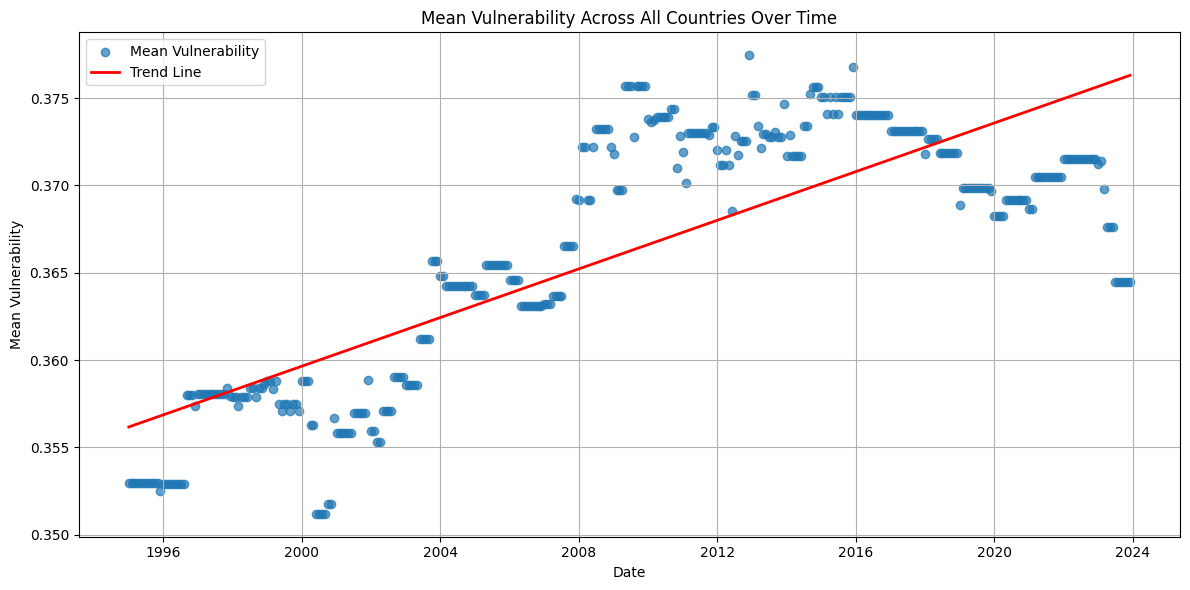

In [19]:
# Calculate the mean vulnerability across all countries over time
vuln_mean_over_time = df_data.groupby('date')['vulnerability'].mean()
print("Mean vulnerability across all countries over time:")
print(vuln_mean_over_time)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Prepare data for trend line
x = pd.to_datetime(vuln_mean_over_time.index)
y = vuln_mean_over_time.values

# Fit a linear trend line
z = np.polyfit(mdates.date2num(x), y, 1)
p = np.poly1d(z)
trend_y = p(mdates.date2num(x))

plt.figure(figsize=(12, 6))
plt.scatter(x, y, label='Mean Vulnerability', alpha=0.7)
plt.plot(x, trend_y, color='red', linewidth=2, label='Trend Line')
plt.title('Mean Vulnerability Across All Countries Over Time')
plt.xlabel('Date')
plt.ylabel('Mean Vulnerability')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Save the figure
plt.savefig("mean_vulnerability_trend.png", dpi=150)
plt.show()




### Sovereign yield spreads overtime


## A. Compute within / between variance (ICC)

In [28]:
import pandas as pd
import numpy as np

# df: country-month panel
# ensure date is datetime and data sorted
df_data['date'] = pd.to_datetime(df_data['date'])
df_data = df_data.sort_values(['iso3c','date'])

# treatment column name
tcol = 'vulnerability'  # replace with your ND-GAIN column name

# total variance
total_var = df_data[tcol].var(ddof=1)

# between variance: variance of country means (across countries)
country_means = df_data.groupby('iso3c')[tcol].mean()
between_var = country_means.var(ddof=1)

# within variance = total - between (can be slightly negative numerically -> clip to 0)
within_var = max(total_var - between_var, 0.0)

within_share = within_var / total_var if total_var != 0 else np.nan

print(f"Total var = {total_var:.6f}, Between = {between_var:.6f}, Within = {within_var:.6f}")
print(f"Share within = {within_share:.2%}")

Total var = 0.005239, Between = 0.005445, Within = 0.000000
Share within = 0.00%


In [29]:
# assumes df has columns: iso3c, date (datetime), NDGAIN (T), and subcomponents like gain_water, gain_infra...
df_data['year'] = df_data['date'].dt.year

# 1) annual aggregation (mean)
ann = df_data.groupby(['iso3c','year'])['vulnerability'].mean().reset_index()

# within/between at annual level
total_var = ann['vulnerability'].var(ddof=1)
between_var = ann.groupby('iso3c')['vulnerability'].mean().var(ddof=1)
within_var = max(total_var - between_var, 0)
print("Annual: total", total_var, "between", between_var, "within", within_var, "share within:", within_var/total_var)



Annual: total 0.005260837640029446 between 0.0054711500036177555 within 0 share within: 0.0


In [31]:
# compute country-year diffs
ann = df_data.groupby(['iso3c','year'])['vulnerability'].mean().unstack('year')
# easier: within country pct change
ann_long = ann.stack().reset_index().rename(columns={0:'vulnerability'})
ann_long['diff1'] = ann_long.groupby('iso3c')['vulnerability'].diff(1)
ann_long['diff5'] = ann_long.groupby('iso3c')['vulnerability'].diff(5)  # 5 year diff
print(ann_long['diff1'].describe())

count    1468.000000
mean       -0.000746
std         0.003003
min        -0.025922
25%        -0.001829
50%        -0.000546
75%         0.000429
max         0.029062
Name: diff1, dtype: float64
